In [1]:
from scipy import misc, ndimage, signal
from sklearn.model_selection  import train_test_split
import numpy
import numpy as np
import random
import ntpath
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import tensorflow as tf
from tensorflow.keras import optimizers 
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from time import time
import time as tm
import datetime
from operator import itemgetter
import glob
from tensorflow.keras.utils import *
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.utils
from numpy import argmax
import seaborn as sn 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
def metrics(Y_validation,predictions):
    
    classes = len(numpy.unique(Y_validation))
    print('Accuracy:', accuracy_score(Y_validation, predictions))
    print('F1 score:', f1_score(Y_validation, predictions,average='weighted'))
    print('Recall:', recall_score(Y_validation, predictions,average='weighted'))
    print('Precision:', precision_score(Y_validation, predictions, average='weighted'))
    print('\n clasification report:\n', classification_report(Y_validation, predictions))
    print('\n confusion matrix:\n',confusion_matrix(Y_validation, predictions))
    #Creamos la matriz de confusión
    snn_cm = confusion_matrix(Y_validation, predictions)

    # Visualizamos la matriz de confusión
    snn_df_cm = pd.DataFrame(snn_cm, range(classes), range(classes))  
    plt.figure(figsize = (20,14))  
    sn.set(font_scale=1.4) #for label size  
    sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
    plt.show()

In [4]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_f1_m:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_f1_m', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)

    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=1)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [5]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'f1_m':f1_m})
            loss,accuracy = model.evaluate(X_test, y_test,verbose=0)
            print(f'Loss={loss:.4f} y F1-Score={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y F1-Score={B_accuracy:0.4f}'+'\n')

In [6]:
def graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID):
    numbers=AccTest
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Test F1-Score {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['f1_m']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Train F1-Score {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['val_f1_m']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Validation F1-Score {}, Época:{}\n".format(value, index+1))

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        #Plot training & validation accuracy values
        plt.plot(np.concatenate([np.array([accuracyTRAIN]),np.array(history.history['f1_m'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyVALID]),np.array(history.history['val_f1_m'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyTEST]),np.array(AccTest)],axis=0)) #Test
        plt.title('F1-Score Vs Epoch')
        plt.ylabel('F1-Score')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.pdf', format='pdf')     
        #plt.show()
        
        plt.figure(figsize=(10, 10))
        #Plot training & validation loss values
        plt.plot(np.concatenate([np.array([lossTRAIN]),np.array(history.history['loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossVALID]),np.array(history.history['val_loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossTEST]),np.array(LossTest)],axis=0)) #Test
        plt.title('Loss Vs Epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
        plt.show() 

In [7]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'f1_m':f1_m})
            loss,accuracy = model.evaluate(X_test, one_hot_labels_test,verbose=0)
            print(f'Loss={loss:.4f} y F1-Score={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y Accuracy={B_accuracy:0.4f}'+'\n')

In [8]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_f1_m:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_f1_m', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    
    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=1)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [9]:
def TERL():
    tf.keras.backend.clear_session()

    # FNN implemented by Nakano

    # Inputs
    inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2], 1), name="input_1")
    # layer 1
    layers = tf.keras.layers.Conv2D(64, (5, 20), strides=(1,1), activation="relu", use_bias=True)(inputs)
    tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((1, 10), strides= (1, 10))(layers)
    # layer 2
    layers = tf.keras.layers.Conv2D(32, (1, 20), strides=(1,1), activation="relu", use_bias=True)(layers)
    tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((1, 15), strides= (1, 15))(layers)
    # layer 3
    layers = tf.keras.layers.Conv2D(32, (1, 35), strides=(1,1), activation="relu", use_bias=True)(layers)
    tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((1, 15), strides= (1, 15))(layers)
    # layer 4
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(1000,activation="relu")(layers)
    #layers = tf.keras.layers.Dense(1000,activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(layers)
    #layers = tf.keras.layers.Dropout(0.2)(layers)
    #tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.Dense(500,activation="relu")(layers)
    #layers = tf.keras.layers.Dropout(0.05)(layers)
    #layers = tf.keras.layers.Dense(500,activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(layers)
    #tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    # layer 5
    predictions = tf.keras.layers.Dense(21, activation="softmax", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    # optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    # loss function
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    # Compile model
    model.compile(loss=loss_fn, optimizer=opt, metrics=[f1_m])
    return model

# Using self-replication representation (mode 1)

In [10]:
X = np.load('/home/bioml/Projects/PhD/InpactorDB/version_final/Non-Redundant/InpactorDB_Repbase.fasta.filtered_self.npy')
Y = np.load('/home/bioml/Projects/PhD/InpactorDB/version_final/Non-Redundant/InpactorDB_Repbase.fasta.filtered_self_labels.npy')

print(X.shape)
print(Y.shape)

(2842, 5, 22576)
(2842, 1)


In [11]:
#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_train, X_test_dev, Y_train, Y_test_dev = train_test_split(X, Y, test_size=validation_size, random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)

print(X_train.shape)
print(Y_train.shape)
print(X_dev.shape)
print(Y_dev.shape)
print(X_test.shape)
print(Y_test.shape)

X = None
Y = None
path_log_base = './logs_CNN'

(2273, 5, 22576)
(2273, 1)
(284, 5, 22576)
(284, 1)
(285, 5, 22576)
(285, 1)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 22576, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 22557, 64)      6464      
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 2255, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 2236, 32)       40992     
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 149, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 115, 32)        35872     
_________________________________________________________________
average_pooling2d_2 (Average (None, 1, 7, 32)          0     

72/72 [==============================] - 1s 19ms/step - loss: 0.0181 - f1_m: 0.9944 - val_loss: 0.5912 - val_f1_m: 0.8983
Epoch 49/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0169 - f1_m: 0.9954 - val_loss: 0.6942 - val_f1_m: 0.8894
Epoch 50/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0213 - f1_m: 0.9961 - val_loss: 0.8354 - val_f1_m: 0.8611
Epoch 51/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0860 - f1_m: 0.9754 - val_loss: 0.7100 - val_f1_m: 0.8344
Epoch 52/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0442 - f1_m: 0.9859 - val_loss: 0.7316 - val_f1_m: 0.8824
Epoch 53/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0238 - f1_m: 0.9930 - val_loss: 0.7139 - val_f1_m: 0.9049
Epoch 54/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0067 - f1_m: 0.9985 - val_loss: 0.7257 - val_f1_m: 0.8969
Epoch 55/100
72/72 [==============================] - 1s 19ms/step -

Loss=0.5384 y F1-Score=0.8138

saved-model-017-0.8238.hdf5
Loss=0.6561 y F1-Score=0.7920

saved-model-018-0.8280.hdf5
Loss=0.5763 y F1-Score=0.8447

saved-model-019-0.8372.hdf5
Loss=0.5910 y F1-Score=0.8356

saved-model-020-0.8851.hdf5
Loss=0.5595 y F1-Score=0.8357

saved-model-021-0.8554.hdf5
Loss=0.5837 y F1-Score=0.8543

saved-model-022-0.8829.hdf5
Loss=0.4203 y F1-Score=0.8779

saved-model-023-0.8896.hdf5
Loss=0.5176 y F1-Score=0.8547

saved-model-024-0.8409.hdf5
Loss=0.6004 y F1-Score=0.8670

saved-model-025-0.8709.hdf5
Loss=0.5308 y F1-Score=0.8660

saved-model-026-0.8794.hdf5
Loss=0.4448 y F1-Score=0.8850

saved-model-027-0.8378.hdf5
Loss=0.6763 y F1-Score=0.8438

saved-model-028-0.8812.hdf5
Loss=0.4650 y F1-Score=0.8791

saved-model-029-0.8778.hdf5
Loss=0.6083 y F1-Score=0.8640

saved-model-030-0.8794.hdf5
Loss=0.4996 y F1-Score=0.8652

saved-model-031-0.8609.hdf5
Loss=0.6016 y F1-Score=0.8599

saved-model-032-0.8859.hdf5
Loss=0.4850 y F1-Score=0.8836

saved-model-033-0.8740.hd

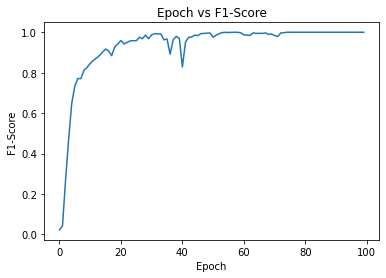

Test F1-Score 0.9100224375724792, Época:58

Test F1-Score 0.9083690643310547, Época:57

Test F1-Score 0.9051723480224609, Época:80

Test F1-Score 0.9051723480224609, Época:84

Test F1-Score 0.9051723480224609, Época:85


Train F1-Score 1.0, Época:58

Train F1-Score 1.0, Época:75

Train F1-Score 1.0, Época:76

Train F1-Score 1.0, Época:77

Train F1-Score 1.0, Época:78


Validation F1-Score 0.9048740863800049, Época:53

Validation F1-Score 0.9004077911376953, Época:58

Validation F1-Score 0.8983134031295776, Época:48

Validation F1-Score 0.8969355821609497, Época:54

Validation F1-Score 0.8968804478645325, Época:59



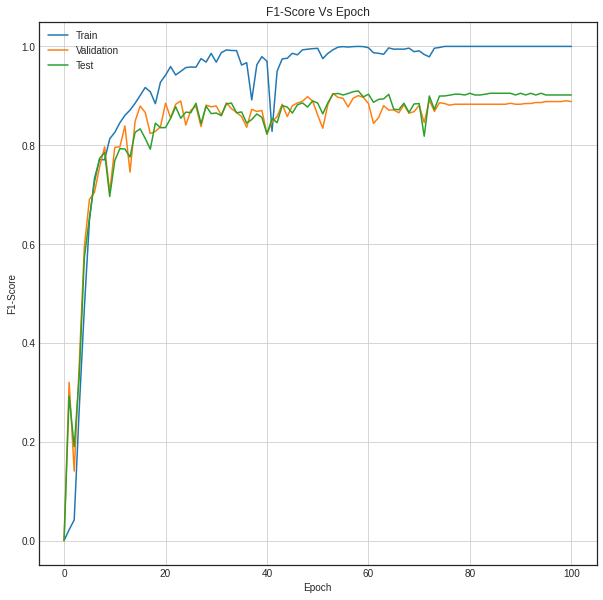

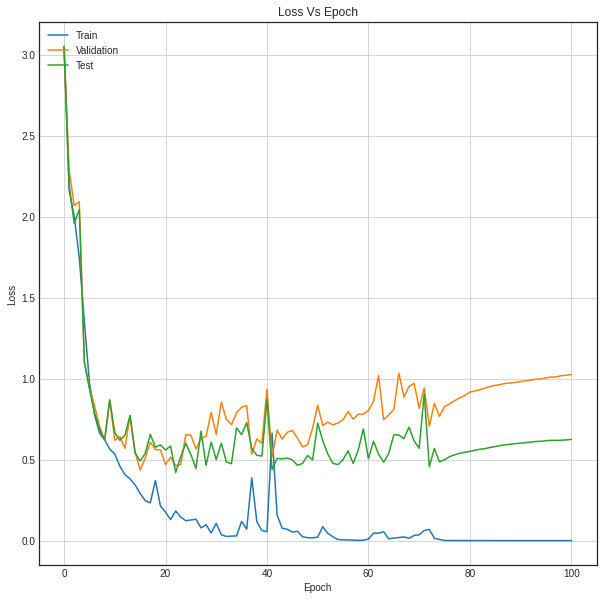

Baseline Error train: 0.00%
Baseline Error dev: 11.16%
Baseline Error test: 9.83%
Accuracy: 1.0
F1 score: 1.0
Recall: 1.0
Precision: 1.0

 clasification report:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       667
         3.0       1.00      1.00      1.00        24
         4.0       1.00      1.00      1.00        28
         9.0       1.00      1.00      1.00       372
        12.0       1.00      1.00      1.00       210
        13.0       1.00      1.00      1.00        55
        14.0       1.00      1.00      1.00        79
        16.0       1.00      1.00      1.00        19
        17.0       1.00      1.00      1.00       443
        18.0       1.00      1.00      1.00       133
        19.0       1.00      1.00      1.00        82
        20.0       1.00      1.00      1.00       161

    accuracy                           1.00      2273
   macro avg       1.00      1.00      1.00      2273
weighted avg       1.00   

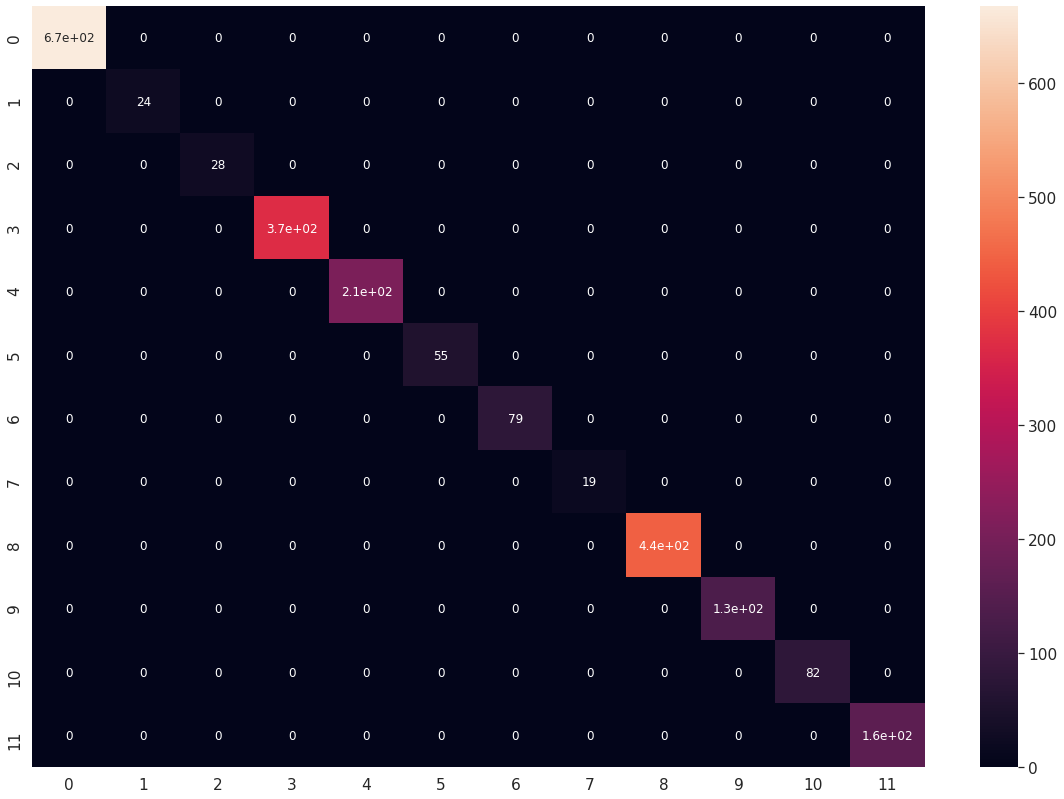

Accuracy: 0.8873239436619719
F1 score: 0.8877000241220416
Recall: 0.8873239436619719
Precision: 0.8933710492940574

 clasification report:
               precision    recall  f1-score   support

         1.0       0.98      0.99      0.98        88
         3.0       0.80      0.80      0.80         5
         4.0       0.71      0.71      0.71         7
         9.0       0.86      0.94      0.90        34
        12.0       0.82      0.82      0.82        34
        13.0       1.00      0.50      0.67         2
        14.0       0.62      0.91      0.74        11
        16.0       0.67      0.67      0.67         3
        17.0       0.95      0.85      0.90        48
        18.0       0.87      0.87      0.87        15
        19.0       0.82      0.82      0.82        17
        20.0       0.88      0.75      0.81        20

    accuracy                           0.89       284
   macro avg       0.83      0.80      0.81       284
weighted avg       0.89      0.89      0.89     

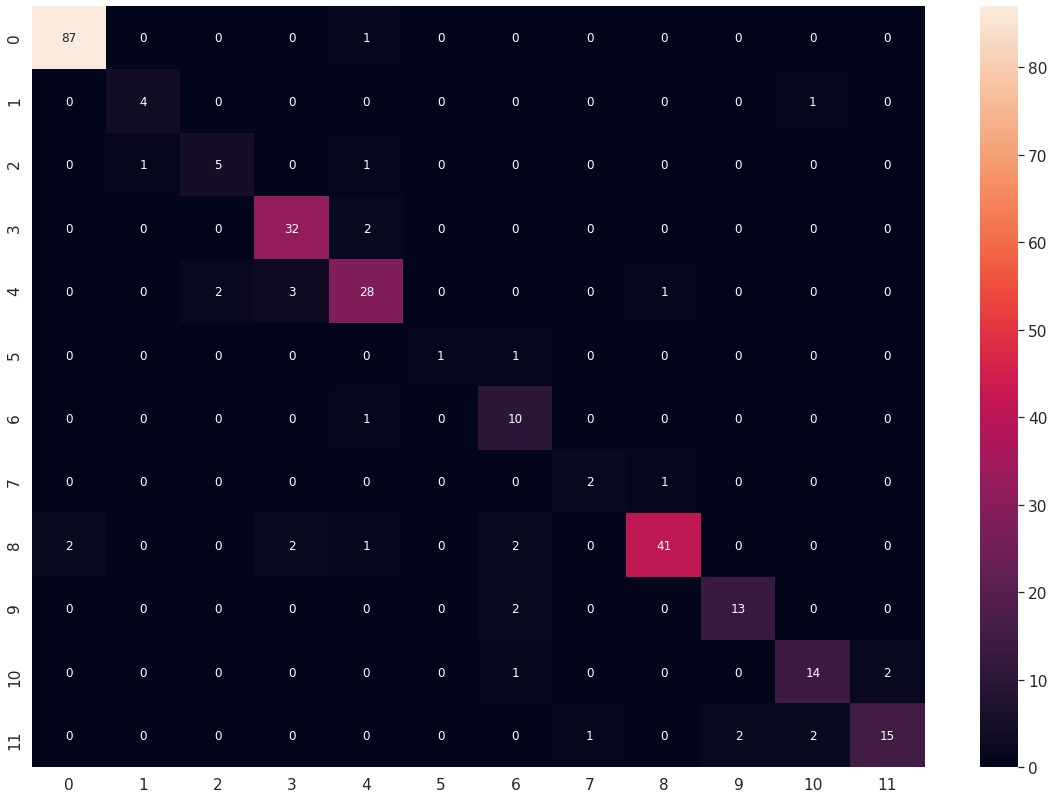

Accuracy: 0.9017543859649123
F1 score: 0.8987780202466099
Recall: 0.9017543859649123
Precision: 0.9016856504404642

 clasification report:
               precision    recall  f1-score   support

         1.0       0.95      0.96      0.96        79
         3.0       0.67      0.67      0.67         3
         4.0       0.00      0.00      0.00         1
         9.0       0.88      0.92      0.90        39
        12.0       0.88      0.76      0.81        37
        13.0       1.00      0.67      0.80         6
        14.0       1.00      1.00      1.00        11
        16.0       0.67      0.40      0.50         5
        17.0       0.91      0.97      0.94        60
        18.0       0.78      1.00      0.88        14
        19.0       0.71      0.62      0.67         8
        20.0       1.00      0.95      0.98        22

    accuracy                           0.90       285
   macro avg       0.79      0.74      0.76       285
weighted avg       0.90      0.90      0.90     

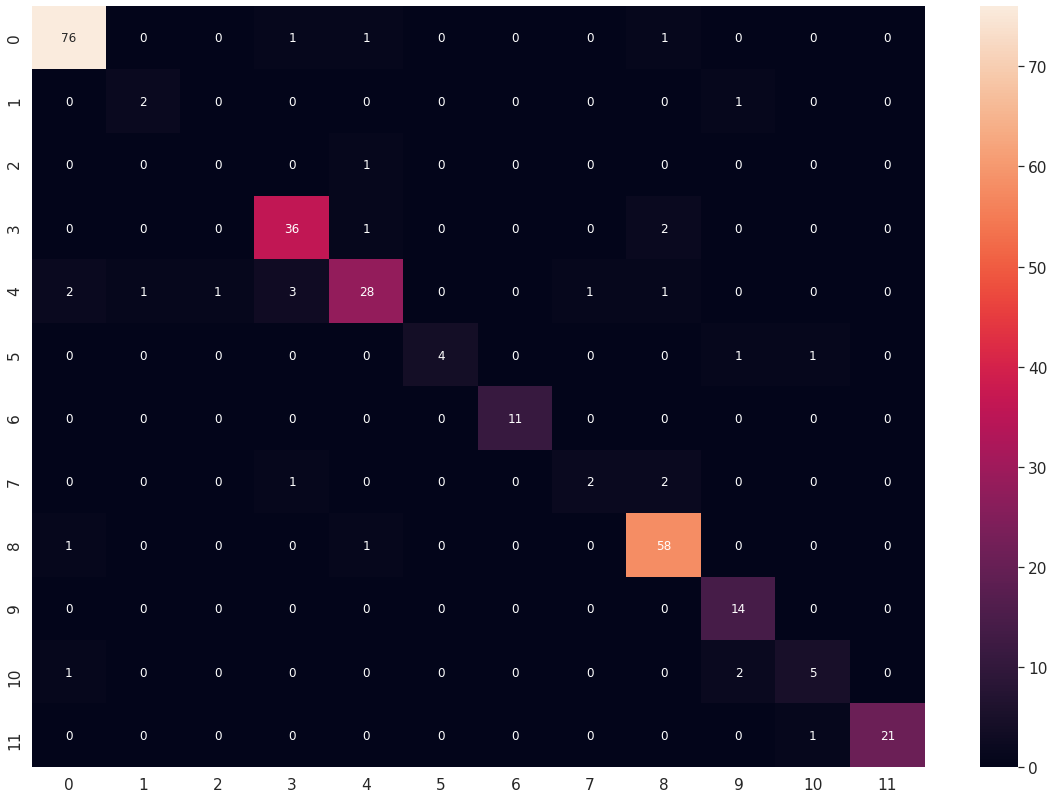

In [12]:
model = TERL()
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

one_hot_labels_train = tf.keras.utils.to_categorical(Y_train, num_classes=21)
one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=21)

# Fit the model
epochs = 100
batch_size = 32

train(model, X_train, one_hot_labels_train, X_dev, one_hot_labels_validation, X_test, one_hot_labels_test, batch_size, epochs, "TERL")
Final_Results_Test(log_Dir) 

# plot metrics
plt.plot(history.history['f1_m'])
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Epoch vs F1-Score')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)

scores = model.evaluate(X_train, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_dev, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_test, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_train)

metrics(Y_train, [argmax(x) for x in predictions])

predictions = model.predict(X_dev)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_test)

metrics(Y_test, [argmax(x) for x in predictions])

# Using zeros representation (mode 2)

In [16]:
X = np.load('/home/bioml/Projects/PhD/InpactorDB/version_final/Non-Redundant/InpactorDB_Repbase.fasta.filtered_zeros.npy')
Y = np.load('/home/bioml/Projects/PhD/InpactorDB/version_final/Non-Redundant/InpactorDB_Repbase.fasta.filtered_zeros_labels.npy')

print(X.shape)
print(Y.shape)

(2842, 5, 22576)
(2842, 1)


In [17]:
#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_train, X_test_dev, Y_train, Y_test_dev = train_test_split(X, Y, test_size=validation_size, random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)

print(X_train.shape)
print(Y_train.shape)
print(X_dev.shape)
print(Y_dev.shape)
print(X_test.shape)
print(Y_test.shape)

X = None
Y = None
path_log_base = './logs_CNN'

(2273, 5, 22576)
(2273, 1)
(284, 5, 22576)
(284, 1)
(285, 5, 22576)
(285, 1)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 22576, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 22557, 64)      6464      
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 2255, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 2236, 32)       40992     
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 149, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 115, 32)        35872     
_________________________________________________________________
average_pooling2d_2 (Average (None, 1, 7, 32)          0     

Epoch 47/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0013 - f1_m: 1.0000 - val_loss: 0.4178 - val_f1_m: 0.9233
Epoch 48/100
72/72 [==============================] - 1s 19ms/step - loss: 9.8892e-04 - f1_m: 1.0000 - val_loss: 0.4350 - val_f1_m: 0.9303
Epoch 49/100
72/72 [==============================] - 1s 19ms/step - loss: 4.0612e-04 - f1_m: 1.0000 - val_loss: 0.4523 - val_f1_m: 0.9338
Epoch 50/100
72/72 [==============================] - 1s 19ms/step - loss: 3.0446e-04 - f1_m: 1.0000 - val_loss: 0.4646 - val_f1_m: 0.9303
Epoch 51/100
72/72 [==============================] - 1s 19ms/step - loss: 2.4254e-04 - f1_m: 1.0000 - val_loss: 0.4662 - val_f1_m: 0.9318
Epoch 52/100
72/72 [==============================] - 1s 19ms/step - loss: 1.9063e-04 - f1_m: 1.0000 - val_loss: 0.4693 - val_f1_m: 0.9338
Epoch 53/100
72/72 [==============================] - 1s 19ms/step - loss: 1.6008e-04 - f1_m: 1.0000 - val_loss: 0.4785 - val_f1_m: 0.9372
Epoch 54/100
72/72 [===========

Loss=0.3979 y F1-Score=0.8682

saved-model-012-0.8776.hdf5
Loss=0.3993 y F1-Score=0.8769

saved-model-013-0.8617.hdf5
Loss=0.4232 y F1-Score=0.8611

saved-model-014-0.9081.hdf5
Loss=0.3380 y F1-Score=0.8922

saved-model-015-0.9060.hdf5
Loss=0.3513 y F1-Score=0.8963

saved-model-016-0.8807.hdf5
Loss=0.3139 y F1-Score=0.8988

saved-model-017-0.9084.hdf5
Loss=0.3111 y F1-Score=0.8844

saved-model-018-0.9135.hdf5
Loss=0.2723 y F1-Score=0.9076

saved-model-019-0.8751.hdf5
Loss=0.3992 y F1-Score=0.9000

saved-model-020-0.9293.hdf5
Loss=0.3813 y F1-Score=0.8913

saved-model-021-0.9134.hdf5
Loss=0.3577 y F1-Score=0.8936

saved-model-022-0.9241.hdf5
Loss=0.2968 y F1-Score=0.9176

saved-model-023-0.9179.hdf5
Loss=0.2774 y F1-Score=0.9104

saved-model-024-0.9101.hdf5
Loss=0.2976 y F1-Score=0.9126

saved-model-025-0.9421.hdf5
Loss=0.3269 y F1-Score=0.9068

saved-model-026-0.9174.hdf5
Loss=0.2716 y F1-Score=0.9335

saved-model-027-0.9227.hdf5
Loss=0.2605 y F1-Score=0.9207

saved-model-028-0.9147.hd

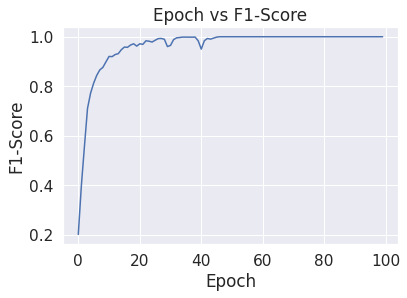

Test F1-Score 0.9440852403640747, Época:81

Test F1-Score 0.9440852403640747, Época:91

Test F1-Score 0.9440852403640747, Época:92

Test F1-Score 0.9440852403640747, Época:93

Test F1-Score 0.9440852403640747, Época:94


Train F1-Score 1.0, Época:47

Train F1-Score 1.0, Época:48

Train F1-Score 1.0, Época:49

Train F1-Score 1.0, Época:50

Train F1-Score 1.0, Época:51


Validation F1-Score 0.9420744776725769, Época:25

Validation F1-Score 0.9406967163085938, Época:56

Validation F1-Score 0.9406967163085938, Época:59

Validation F1-Score 0.9406967163085938, Época:62

Validation F1-Score 0.9406967163085938, Época:63



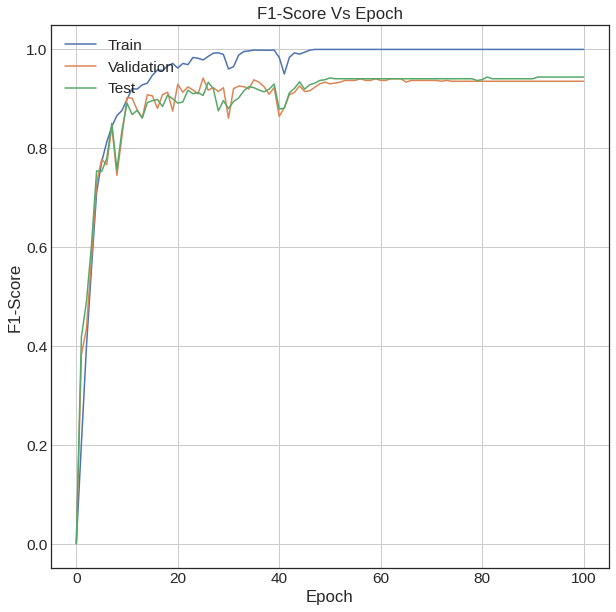

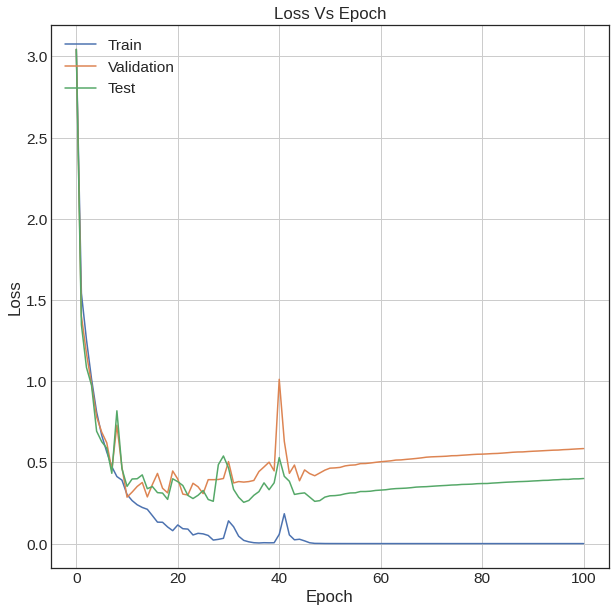

Baseline Error train: 0.00%
Baseline Error dev: 6.44%
Baseline Error test: 5.59%
Accuracy: 1.0
F1 score: 1.0
Recall: 1.0
Precision: 1.0

 clasification report:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       667
         3.0       1.00      1.00      1.00        24
         4.0       1.00      1.00      1.00        28
         9.0       1.00      1.00      1.00       372
        12.0       1.00      1.00      1.00       210
        13.0       1.00      1.00      1.00        55
        14.0       1.00      1.00      1.00        79
        16.0       1.00      1.00      1.00        19
        17.0       1.00      1.00      1.00       443
        18.0       1.00      1.00      1.00       133
        19.0       1.00      1.00      1.00        82
        20.0       1.00      1.00      1.00       161

    accuracy                           1.00      2273
   macro avg       1.00      1.00      1.00      2273
weighted avg       1.00    

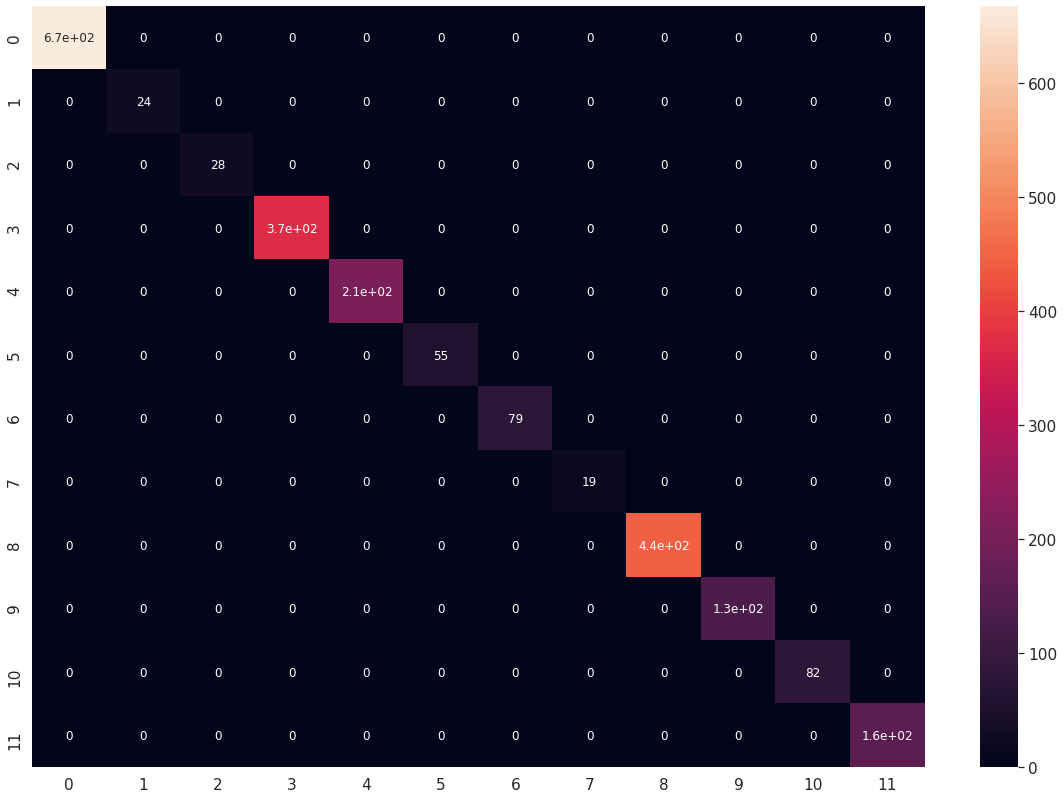

Accuracy: 0.9366197183098591
F1 score: 0.9364812122404403
Recall: 0.9366197183098591
Precision: 0.938777789009442

 clasification report:
               precision    recall  f1-score   support

         1.0       0.98      1.00      0.99        88
         3.0       1.00      0.80      0.89         5
         4.0       1.00      1.00      1.00         7
         9.0       0.84      0.94      0.89        34
        12.0       0.91      0.88      0.90        34
        13.0       1.00      1.00      1.00         2
        14.0       0.89      0.73      0.80        11
        16.0       0.75      1.00      0.86         3
        17.0       1.00      0.96      0.98        48
        18.0       0.80      0.80      0.80        15
        19.0       1.00      0.94      0.97        17
        20.0       0.90      0.90      0.90        20

    accuracy                           0.94       284
   macro avg       0.92      0.91      0.91       284
weighted avg       0.94      0.94      0.94      

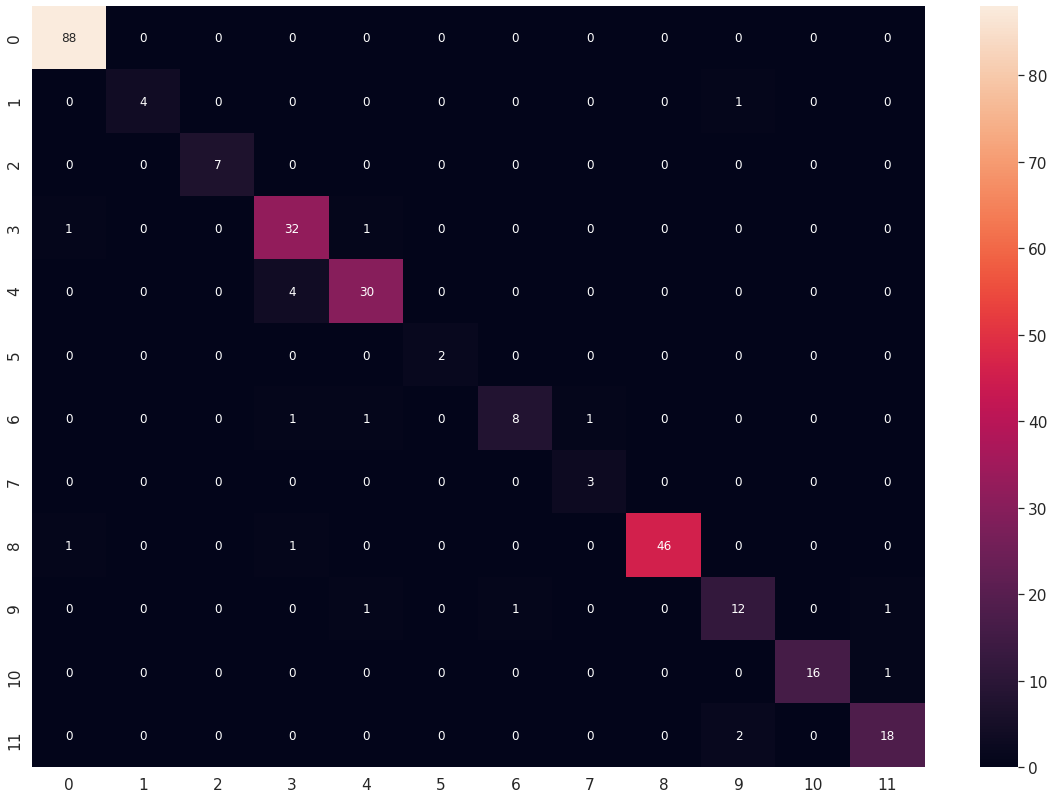

Accuracy: 0.9438596491228071
F1 score: 0.9449975720684438
Recall: 0.9438596491228071
Precision: 0.9506472921470358

 clasification report:
               precision    recall  f1-score   support

         1.0       0.99      0.97      0.98        79
         3.0       0.67      0.67      0.67         3
         4.0       0.50      1.00      0.67         1
         9.0       0.93      0.97      0.95        39
        12.0       1.00      0.89      0.94        37
        13.0       1.00      0.83      0.91         6
        14.0       1.00      0.91      0.95        11
        16.0       1.00      0.80      0.89         5
        17.0       0.97      0.98      0.98        60
        18.0       0.74      1.00      0.85        14
        19.0       0.75      0.75      0.75         8
        20.0       0.95      0.91      0.93        22

    accuracy                           0.94       285
   macro avg       0.87      0.89      0.87       285
weighted avg       0.95      0.94      0.94     

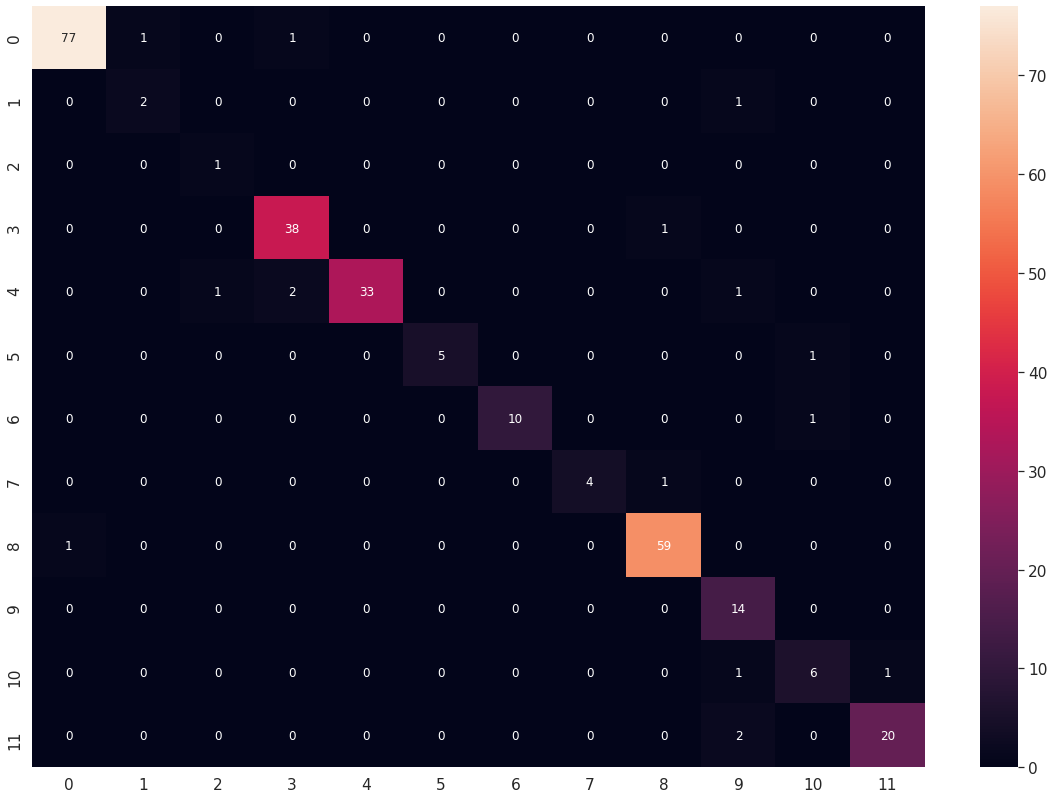

In [18]:
model = TERL()
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

one_hot_labels_train = tf.keras.utils.to_categorical(Y_train, num_classes=21)
one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=21)

# Fit the model
epochs = 100
batch_size = 32

train(model, X_train, one_hot_labels_train, X_dev, one_hot_labels_validation, X_test, one_hot_labels_test, batch_size, epochs, "TERL")
Final_Results_Test(log_Dir) 

# plot metrics
plt.plot(history.history['f1_m'])
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Epoch vs F1-Score')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)

scores = model.evaluate(X_train, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_dev, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_test, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_train)

metrics(Y_train, [argmax(x) for x in predictions])

predictions = model.predict(X_dev)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_test)

metrics(Y_test, [argmax(x) for x in predictions])

# Using NNs filling (method 3)

In [19]:
X = np.load('/home/bioml/Projects/PhD/InpactorDB/version_final/Non-Redundant/InpactorDB_Repbase.fasta.filtered_NNs.npy')
Y = np.load('/home/bioml/Projects/PhD/InpactorDB/version_final/Non-Redundant/InpactorDB_Repbase.fasta.filtered_NNs_labels.npy')

print(X.shape)
print(Y.shape)

(2842, 5, 22576)
(2842, 1)


In [20]:
#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_train, X_test_dev, Y_train, Y_test_dev = train_test_split(X, Y, test_size=validation_size, random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)

print(X_train.shape)
print(Y_train.shape)
print(X_dev.shape)
print(Y_dev.shape)
print(X_test.shape)
print(Y_test.shape)

X = None
Y = None
path_log_base = './logs_CNN'

(2273, 5, 22576)
(2273, 1)
(284, 5, 22576)
(284, 1)
(285, 5, 22576)
(285, 1)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 22576, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 22557, 64)      6464      
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 2255, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 2236, 32)       40992     
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 149, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 115, 32)        35872     
_________________________________________________________________
average_pooling2d_2 (Average (None, 1, 7, 32)          0     

Epoch 47/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0015 - f1_m: 1.0000 - val_loss: 0.4207 - val_f1_m: 0.9155
Epoch 48/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0010 - f1_m: 1.0000 - val_loss: 0.4197 - val_f1_m: 0.9069
Epoch 49/100
72/72 [==============================] - 1s 19ms/step - loss: 7.7556e-04 - f1_m: 1.0000 - val_loss: 0.4321 - val_f1_m: 0.9085
Epoch 50/100
72/72 [==============================] - 1s 18ms/step - loss: 5.9402e-04 - f1_m: 1.0000 - val_loss: 0.4478 - val_f1_m: 0.9103
Epoch 51/100
72/72 [==============================] - 1s 19ms/step - loss: 4.4188e-04 - f1_m: 1.0000 - val_loss: 0.4662 - val_f1_m: 0.9069
Epoch 52/100
72/72 [==============================] - 1s 19ms/step - loss: 5.0363e-04 - f1_m: 1.0000 - val_loss: 0.4758 - val_f1_m: 0.9069
Epoch 53/100
72/72 [==============================] - 1s 18ms/step - loss: 3.0738e-04 - f1_m: 1.0000 - val_loss: 0.4736 - val_f1_m: 0.9069
Epoch 54/100
72/72 [===============

Loss=0.4925 y F1-Score=0.8208

saved-model-013-0.8552.hdf5
Loss=0.4372 y F1-Score=0.8583

saved-model-014-0.8764.hdf5
Loss=0.4790 y F1-Score=0.8631

saved-model-015-0.8321.hdf5
Loss=0.6017 y F1-Score=0.8048

saved-model-016-0.8639.hdf5
Loss=0.4227 y F1-Score=0.8683

saved-model-017-0.8875.hdf5
Loss=0.3856 y F1-Score=0.8847

saved-model-018-0.9047.hdf5
Loss=0.3671 y F1-Score=0.8956

saved-model-019-0.8844.hdf5
Loss=0.3919 y F1-Score=0.8976

saved-model-020-0.9101.hdf5
Loss=0.3680 y F1-Score=0.8869

saved-model-021-0.8807.hdf5
Loss=0.3701 y F1-Score=0.9000

saved-model-022-0.8715.hdf5
Loss=0.4184 y F1-Score=0.8853

saved-model-023-0.9142.hdf5
Loss=0.3749 y F1-Score=0.8881

saved-model-024-0.9173.hdf5
Loss=0.3686 y F1-Score=0.9016

saved-model-025-0.8938.hdf5
Loss=0.4356 y F1-Score=0.8817

saved-model-026-0.8785.hdf5
Loss=0.6423 y F1-Score=0.8326

saved-model-027-0.9106.hdf5
Loss=0.3723 y F1-Score=0.9009

saved-model-028-0.8880.hdf5
Loss=0.4487 y F1-Score=0.8713

saved-model-029-0.8953.hd

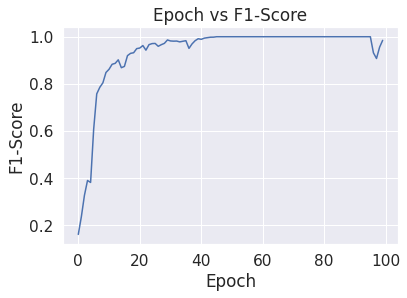

Test F1-Score 0.9259790778160095, Época:39

Test F1-Score 0.9241318106651306, Época:69

Test F1-Score 0.9225334525108337, Época:70

Test F1-Score 0.9224731922149658, Época:100

Test F1-Score 0.9222579598426819, Época:62


Train F1-Score 1.0, Época:46

Train F1-Score 1.0, Época:47

Train F1-Score 1.0, Época:48

Train F1-Score 1.0, Época:49

Train F1-Score 1.0, Época:50


Validation F1-Score 0.9275051951408386, Época:40

Validation F1-Score 0.923828125, Época:37

Validation F1-Score 0.9191467761993408, Época:70

Validation F1-Score 0.9191467761993408, Época:75

Validation F1-Score 0.9191467761993408, Época:76



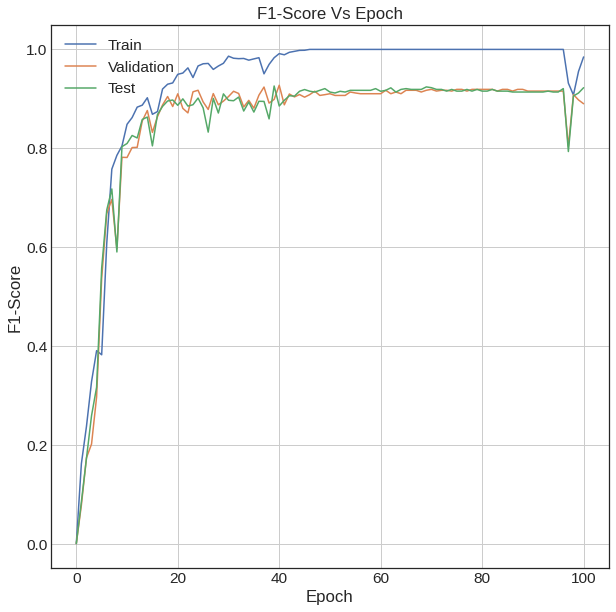

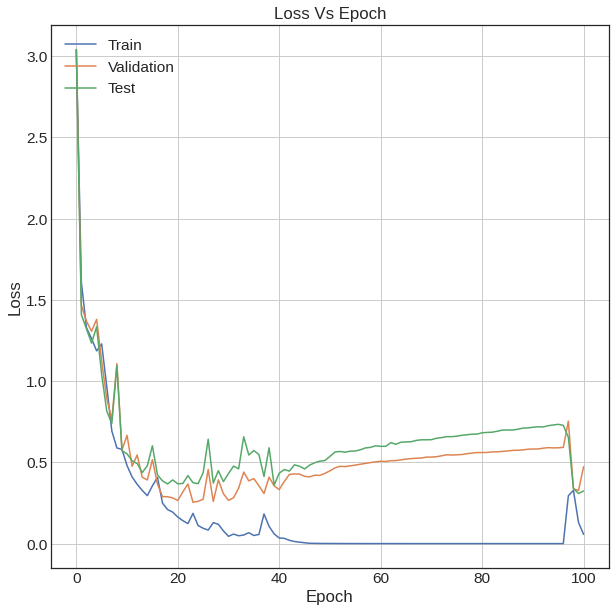

Baseline Error train: 1.72%
Baseline Error dev: 11.00%
Baseline Error test: 7.75%
Accuracy: 0.9832820061592609
F1 score: 0.9835088630915421
Recall: 0.9832820061592609
Precision: 0.9846095811470991

 clasification report:
               precision    recall  f1-score   support

         1.0       1.00      0.99      0.99       667
         3.0       0.96      1.00      0.98        24
         4.0       1.00      1.00      1.00        28
         9.0       0.99      0.95      0.97       372
        12.0       0.89      1.00      0.94       210
        13.0       1.00      0.98      0.99        55
        14.0       1.00      0.95      0.97        79
        16.0       0.95      0.95      0.95        19
        17.0       1.00      0.99      1.00       443
        18.0       0.99      1.00      0.99       133
        19.0       0.98      1.00      0.99        82
        20.0       1.00      0.98      0.99       161

    accuracy                           0.98      2273
   macro avg       0

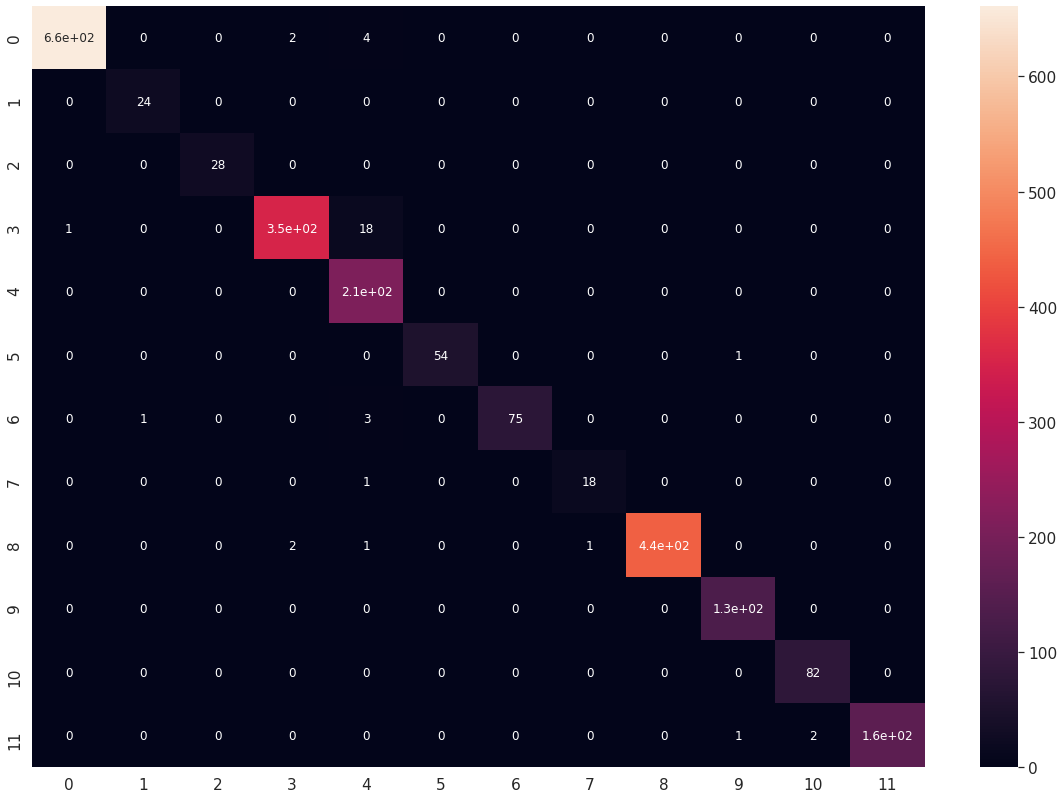

Accuracy: 0.8873239436619719
F1 score: 0.8833636538767718
Recall: 0.8873239436619719
Precision: 0.8882660414900253

 clasification report:
               precision    recall  f1-score   support

         1.0       0.98      0.99      0.98        88
         3.0       0.83      1.00      0.91         5
         4.0       1.00      0.71      0.83         7
         9.0       0.88      0.85      0.87        34
        12.0       0.73      0.88      0.80        34
        13.0       0.00      0.00      0.00         2
        14.0       0.75      0.55      0.63        11
        16.0       0.75      1.00      0.86         3
        17.0       0.98      0.96      0.97        48
        18.0       0.75      0.80      0.77        15
        19.0       0.85      1.00      0.92        17
        20.0       0.86      0.60      0.71        20

    accuracy                           0.89       284
   macro avg       0.78      0.78      0.77       284
weighted avg       0.89      0.89      0.88     

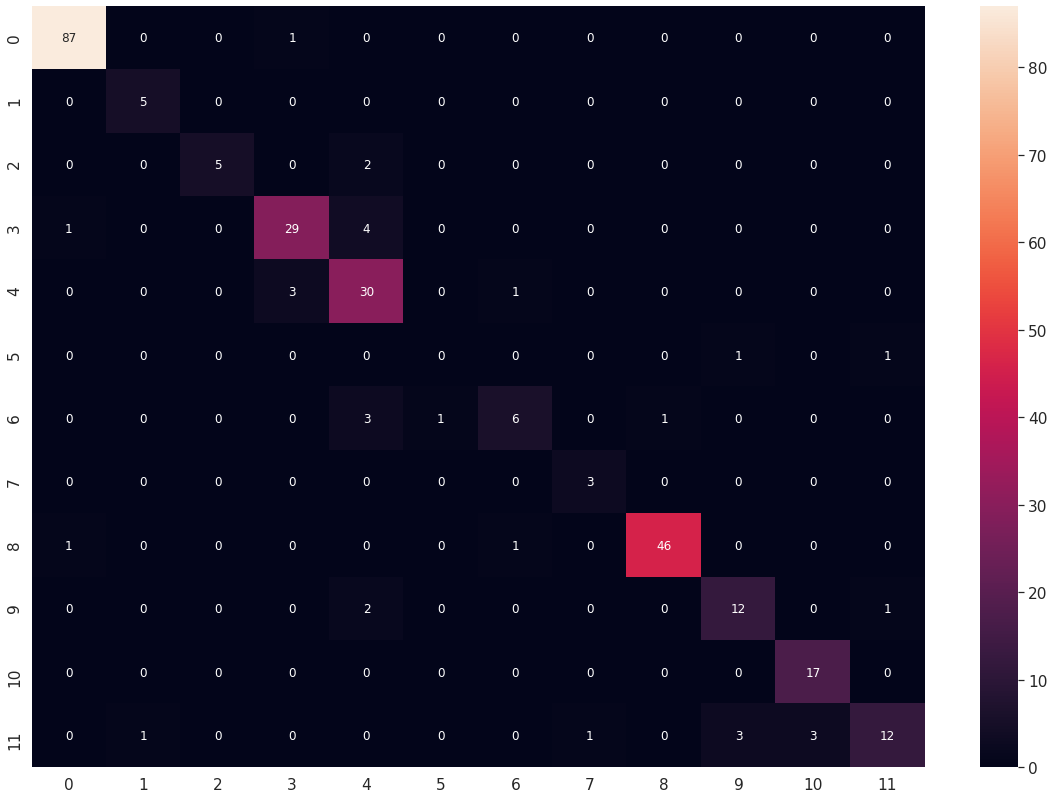

Accuracy: 0.9192982456140351
F1 score: 0.9200348181294928
Recall: 0.9192982456140351
Precision: 0.9264909067540646

 clasification report:
               precision    recall  f1-score   support

         1.0       0.97      0.96      0.97        79
         3.0       0.75      1.00      0.86         3
         4.0       0.50      1.00      0.67         1
         9.0       0.88      0.95      0.91        39
        12.0       0.85      0.89      0.87        37
        13.0       1.00      0.67      0.80         6
        14.0       0.91      0.91      0.91        11
        16.0       1.00      0.60      0.75         5
        17.0       1.00      0.93      0.97        60
        18.0       0.81      0.93      0.87        14
        19.0       0.67      0.75      0.71         8
        20.0       0.95      0.91      0.93        22

    accuracy                           0.92       285
   macro avg       0.86      0.87      0.85       285
weighted avg       0.93      0.92      0.92     

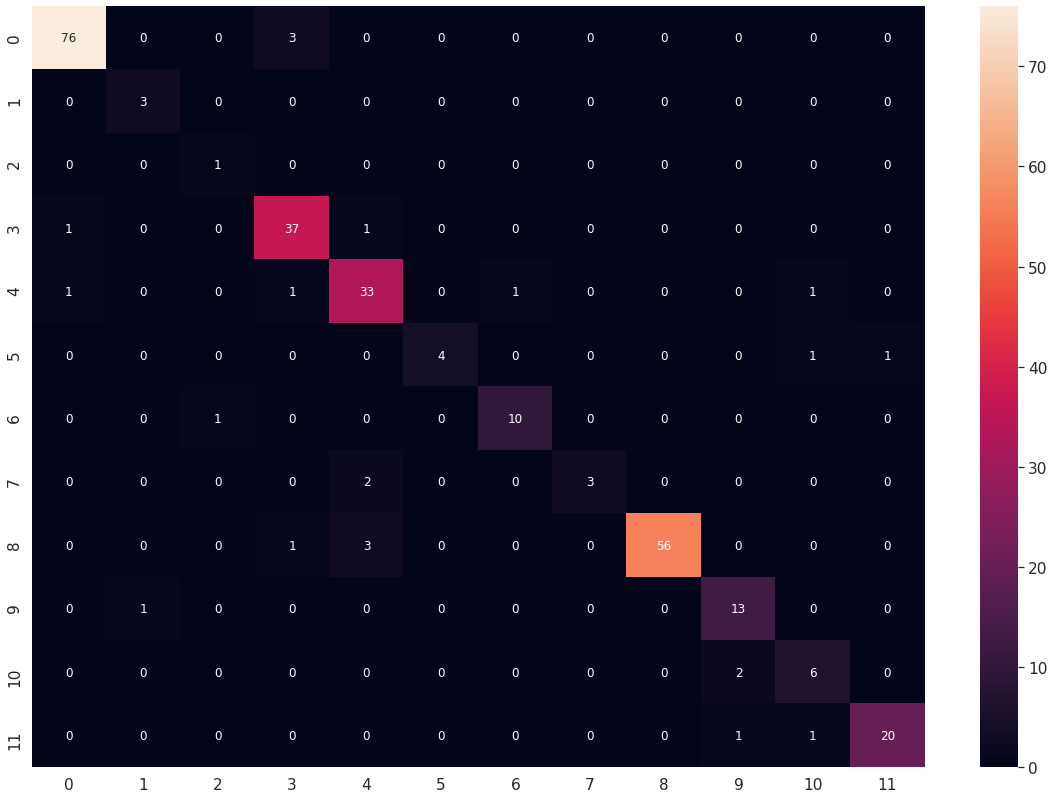

In [21]:
model = TERL()
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

one_hot_labels_train = tf.keras.utils.to_categorical(Y_train, num_classes=21)
one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=21)

# Fit the model
epochs = 100
batch_size = 32

train(model, X_train, one_hot_labels_train, X_dev, one_hot_labels_validation, X_test, one_hot_labels_test, batch_size, epochs, "TERL")
Final_Results_Test(log_Dir) 

# plot metrics
plt.plot(history.history['f1_m'])
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Epoch vs F1-Score')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)

scores = model.evaluate(X_train, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_dev, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_test, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_train)

metrics(Y_train, [argmax(x) for x in predictions])

predictions = model.predict(X_dev)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_test)

metrics(Y_test, [argmax(x) for x in predictions])

# Using Center representation (method 4)

In [22]:
X = np.load('/home/bioml/Projects/PhD/InpactorDB/version_final/Non-Redundant/InpactorDB_Repbase.fasta.filtered_center.npy')
Y = np.load('/home/bioml/Projects/PhD/InpactorDB/version_final/Non-Redundant/InpactorDB_Repbase.fasta.filtered_center_labels.npy')

print(X.shape)
print(Y.shape)

(2842, 5, 22576)
(2842, 1)


In [23]:
#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_train, X_test_dev, Y_train, Y_test_dev = train_test_split(X, Y, test_size=validation_size, random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)

print(X_train.shape)
print(Y_train.shape)
print(X_dev.shape)
print(Y_dev.shape)
print(X_test.shape)
print(Y_test.shape)

X = None
Y = None
path_log_base = './logs_CNN'

(2273, 5, 22576)
(2273, 1)
(284, 5, 22576)
(284, 1)
(285, 5, 22576)
(285, 1)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 22576, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 22557, 64)      6464      
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 2255, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 2236, 32)       40992     
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 149, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 115, 32)        35872     
_________________________________________________________________
average_pooling2d_2 (Average (None, 1, 7, 32)          0     

Epoch 47/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0213 - f1_m: 0.9937 - val_loss: 0.2430 - val_f1_m: 0.9281
Epoch 48/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0120 - f1_m: 0.9967 - val_loss: 0.2383 - val_f1_m: 0.9352
Epoch 49/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0063 - f1_m: 0.9991 - val_loss: 0.2686 - val_f1_m: 0.9365
Epoch 50/100
72/72 [==============================] - 1s 18ms/step - loss: 0.0055 - f1_m: 0.9987 - val_loss: 0.2625 - val_f1_m: 0.9370
Epoch 51/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0032 - f1_m: 0.9998 - val_loss: 0.2795 - val_f1_m: 0.9292
Epoch 52/100
72/72 [==============================] - 1s 18ms/step - loss: 0.0012 - f1_m: 1.0000 - val_loss: 0.2923 - val_f1_m: 0.9207
Epoch 53/100
72/72 [==============================] - 1s 19ms/step - loss: 9.2103e-04 - f1_m: 1.0000 - val_loss: 0.2996 - val_f1_m: 0.9277
Epoch 54/100
72/72 [==============================]

Loss=0.4381 y F1-Score=0.8473

saved-model-014-0.8708.hdf5
Loss=0.4752 y F1-Score=0.8198

saved-model-015-0.8716.hdf5
Loss=0.5120 y F1-Score=0.8344

saved-model-016-0.8800.hdf5
Loss=0.4046 y F1-Score=0.8536

saved-model-017-0.9186.hdf5
Loss=0.4789 y F1-Score=0.8318

saved-model-018-0.8821.hdf5
Loss=0.4758 y F1-Score=0.8274

saved-model-019-0.8654.hdf5
Loss=0.4488 y F1-Score=0.8807

saved-model-020-0.9062.hdf5
Loss=0.3941 y F1-Score=0.8782

saved-model-021-0.9158.hdf5
Loss=0.3853 y F1-Score=0.8687

saved-model-022-0.8941.hdf5
Loss=0.4069 y F1-Score=0.8793

saved-model-023-0.9189.hdf5
Loss=0.3361 y F1-Score=0.8999

saved-model-024-0.9114.hdf5
Loss=0.3785 y F1-Score=0.8722

saved-model-025-0.9071.hdf5
Loss=0.4193 y F1-Score=0.8654

saved-model-026-0.9030.hdf5
Loss=0.3832 y F1-Score=0.8718

saved-model-027-0.9138.hdf5
Loss=0.3385 y F1-Score=0.9002

saved-model-028-0.9099.hdf5
Loss=0.3762 y F1-Score=0.8981

saved-model-029-0.9053.hdf5
Loss=0.3911 y F1-Score=0.8861

saved-model-030-0.9275.hd

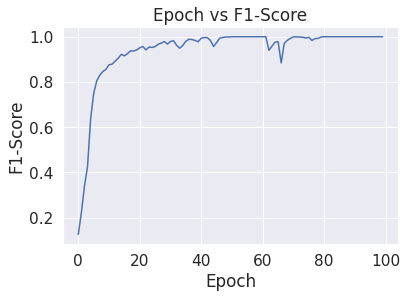

Test F1-Score 0.9457385540008545, Época:83

Test F1-Score 0.9455732703208923, Época:71

Test F1-Score 0.9440852403640747, Época:87

Test F1-Score 0.9440852403640747, Época:88

Test F1-Score 0.9440852403640747, Época:89


Train F1-Score 1.0, Época:52

Train F1-Score 1.0, Época:53

Train F1-Score 1.0, Época:54

Train F1-Score 1.0, Época:55

Train F1-Score 1.0, Época:56


Validation F1-Score 0.954365074634552, Época:71

Validation F1-Score 0.9507274627685547, Época:70

Validation F1-Score 0.9490740895271301, Época:69

Validation F1-Score 0.9474205374717712, Época:72

Validation F1-Score 0.9412893652915955, Época:64



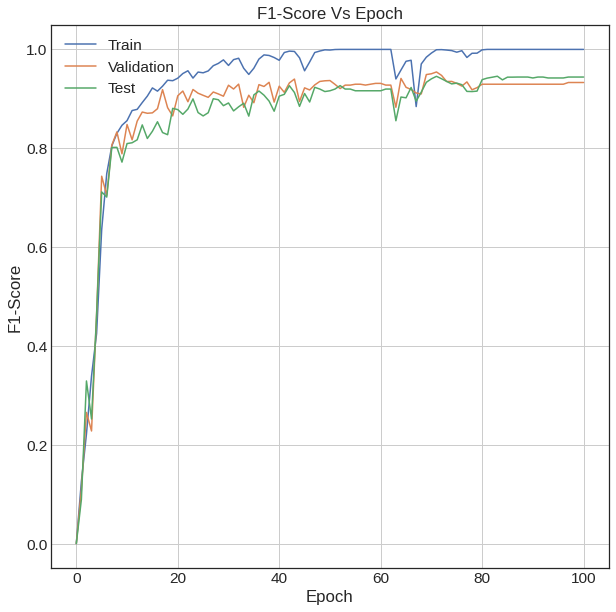

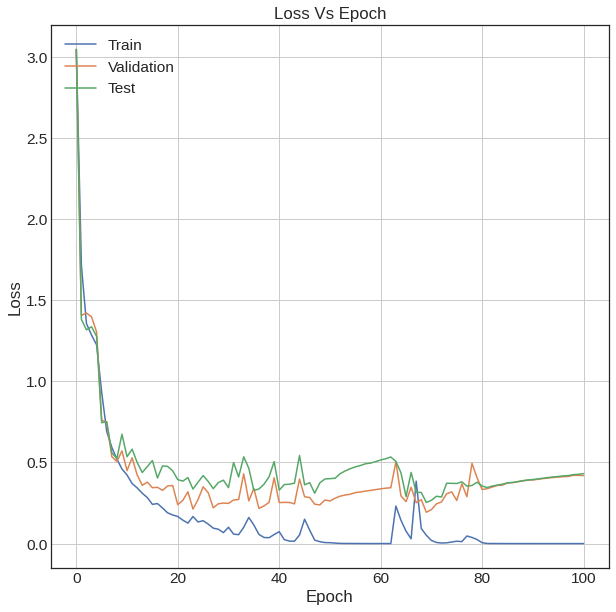

Baseline Error train: 0.00%
Baseline Error dev: 6.70%
Baseline Error test: 5.59%
Accuracy: 1.0
F1 score: 1.0
Recall: 1.0
Precision: 1.0

 clasification report:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       667
         3.0       1.00      1.00      1.00        24
         4.0       1.00      1.00      1.00        28
         9.0       1.00      1.00      1.00       372
        12.0       1.00      1.00      1.00       210
        13.0       1.00      1.00      1.00        55
        14.0       1.00      1.00      1.00        79
        16.0       1.00      1.00      1.00        19
        17.0       1.00      1.00      1.00       443
        18.0       1.00      1.00      1.00       133
        19.0       1.00      1.00      1.00        82
        20.0       1.00      1.00      1.00       161

    accuracy                           1.00      2273
   macro avg       1.00      1.00      1.00      2273
weighted avg       1.00    

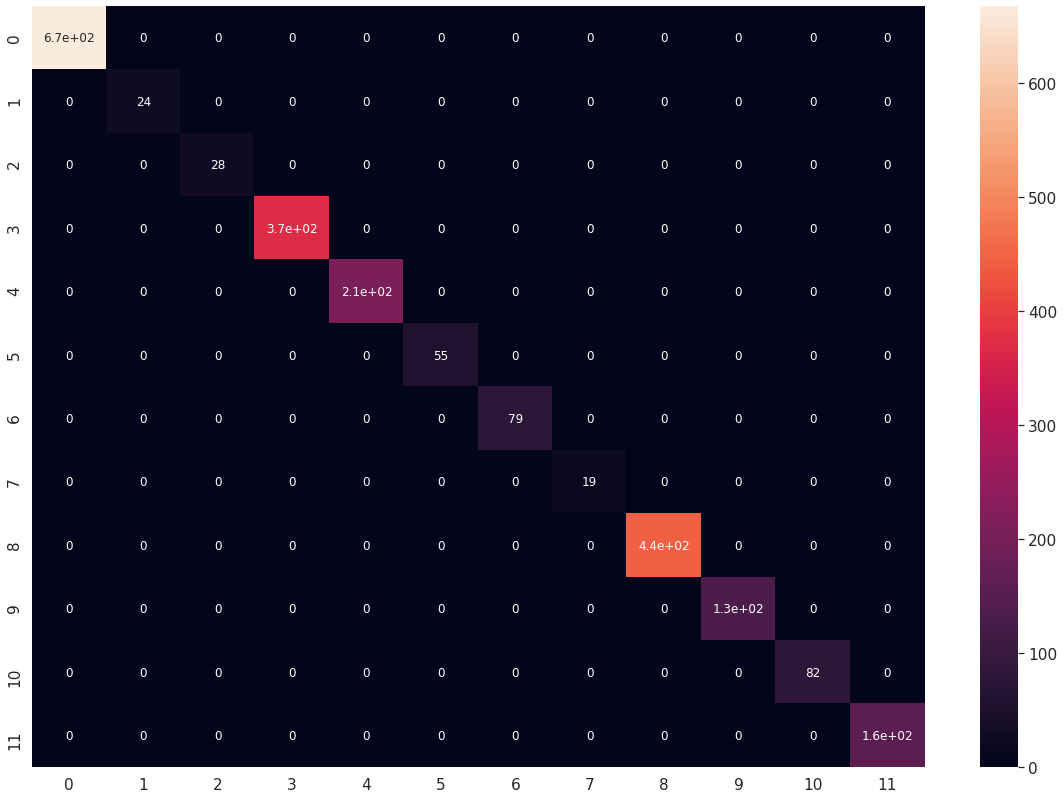

Accuracy: 0.9330985915492958
F1 score: 0.9336997294768715
Recall: 0.9330985915492958
Precision: 0.9388305822303425

 clasification report:
               precision    recall  f1-score   support

         1.0       0.96      0.98      0.97        88
         3.0       1.00      1.00      1.00         5
         4.0       1.00      1.00      1.00         7
         9.0       0.94      0.91      0.93        34
        12.0       0.91      0.94      0.93        34
        13.0       1.00      0.50      0.67         2
        14.0       0.79      1.00      0.88        11
        16.0       0.40      0.67      0.50         3
        17.0       0.98      0.96      0.97        48
        18.0       0.85      0.73      0.79        15
        19.0       1.00      0.82      0.90        17
        20.0       0.95      0.95      0.95        20

    accuracy                           0.93       284
   macro avg       0.90      0.87      0.87       284
weighted avg       0.94      0.93      0.93     

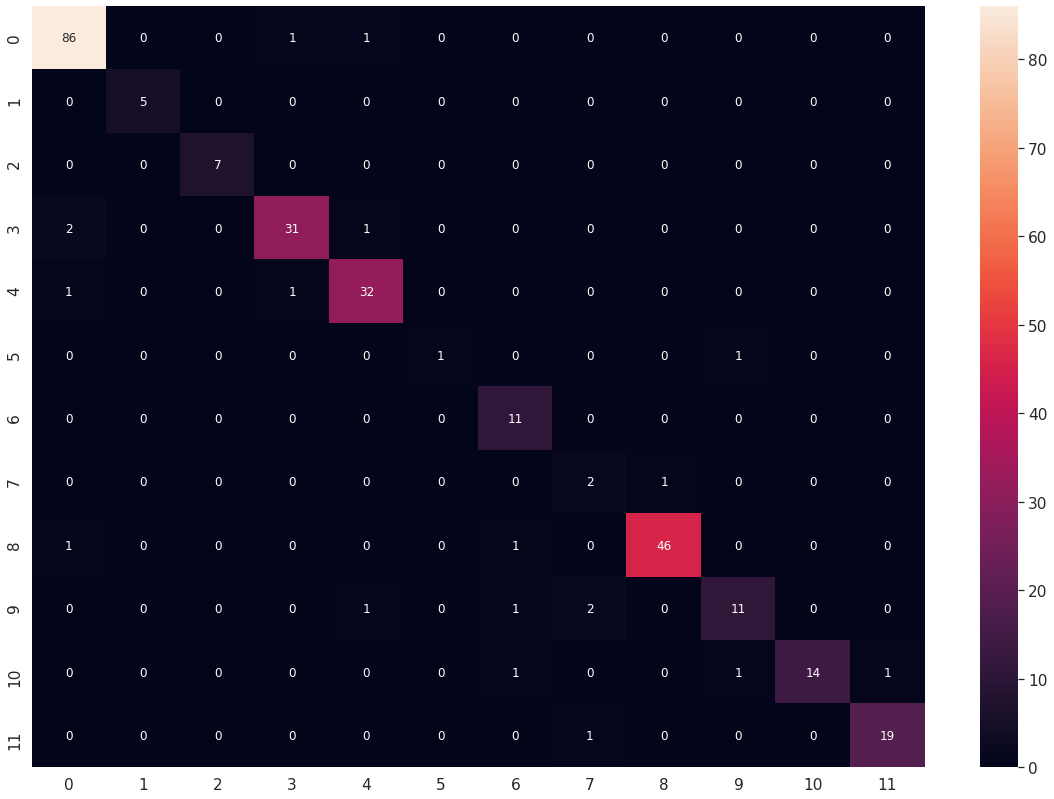

Accuracy: 0.9438596491228071
F1 score: 0.9445799078802174
Recall: 0.9438596491228071
Precision: 0.9474092009685229

 clasification report:
               precision    recall  f1-score   support

         1.0       0.99      0.99      0.99        79
         3.0       1.00      1.00      1.00         3
         4.0       0.50      1.00      0.67         1
         9.0       0.92      0.92      0.92        39
        12.0       0.94      0.89      0.92        37
        13.0       1.00      0.83      0.91         6
        14.0       0.79      1.00      0.88        11
        16.0       0.80      0.80      0.80         5
        17.0       0.98      0.97      0.97        60
        18.0       0.86      0.86      0.86        14
        19.0       0.88      0.88      0.88         8
        20.0       0.95      0.95      0.95        22

    accuracy                           0.94       285
   macro avg       0.88      0.92      0.90       285
weighted avg       0.95      0.94      0.94     

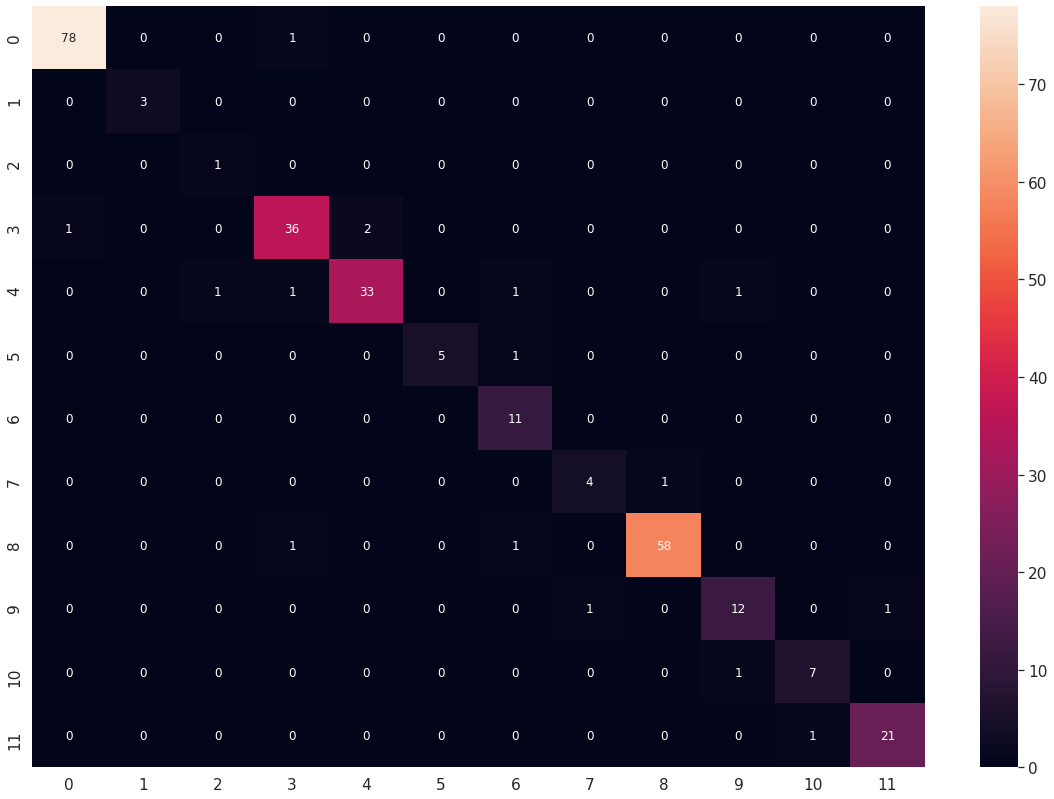

In [24]:
model = TERL()
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

one_hot_labels_train = tf.keras.utils.to_categorical(Y_train, num_classes=21)
one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=21)

# Fit the model
epochs = 100
batch_size = 32

train(model, X_train, one_hot_labels_train, X_dev, one_hot_labels_validation, X_test, one_hot_labels_test, batch_size, epochs, "TERL")
Final_Results_Test(log_Dir) 

# plot metrics
plt.plot(history.history['f1_m'])
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Epoch vs F1-Score')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)

scores = model.evaluate(X_train, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_dev, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_test, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_train)

metrics(Y_train, [argmax(x) for x in predictions])

predictions = model.predict(X_dev)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_test)

metrics(Y_test, [argmax(x) for x in predictions])

# Using Ones representation (method 5)

In [25]:
X = np.load('/home/bioml/Projects/PhD/InpactorDB/version_final/Non-Redundant/InpactorDB_Repbase.fasta.filtered_ones.npy')
Y = np.load('/home/bioml/Projects/PhD/InpactorDB/version_final/Non-Redundant/InpactorDB_Repbase.fasta.filtered_ones_labels.npy')

print(X.shape)
print(Y.shape)

(2842, 5, 22576)
(2842, 1)


In [26]:
#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_train, X_test_dev, Y_train, Y_test_dev = train_test_split(X, Y, test_size=validation_size, random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)

print(X_train.shape)
print(Y_train.shape)
print(X_dev.shape)
print(Y_dev.shape)
print(X_test.shape)
print(Y_test.shape)

X = None
Y = None
path_log_base = './logs_CNN'

(2273, 5, 22576)
(2273, 1)
(284, 5, 22576)
(284, 1)
(285, 5, 22576)
(285, 1)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 22576, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 22557, 64)      6464      
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 2255, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 2236, 32)       40992     
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 149, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 115, 32)        35872     
_________________________________________________________________
average_pooling2d_2 (Average (None, 1, 7, 32)          0     

Epoch 47/100
72/72 [==============================] - 1s 18ms/step - loss: 0.0302 - f1_m: 0.9896 - val_loss: 0.7774 - val_f1_m: 0.8914
Epoch 48/100
72/72 [==============================] - 1s 18ms/step - loss: 0.0414 - f1_m: 0.9854 - val_loss: 0.6375 - val_f1_m: 0.9135
Epoch 49/100
72/72 [==============================] - 1s 18ms/step - loss: 0.0258 - f1_m: 0.9933 - val_loss: 0.5426 - val_f1_m: 0.9251
Epoch 50/100
72/72 [==============================] - 1s 18ms/step - loss: 0.0152 - f1_m: 0.9941 - val_loss: 0.7003 - val_f1_m: 0.9119
Epoch 51/100
72/72 [==============================] - 1s 18ms/step - loss: 0.0188 - f1_m: 0.9941 - val_loss: 0.5924 - val_f1_m: 0.9261
Epoch 52/100
72/72 [==============================] - 1s 18ms/step - loss: 0.0063 - f1_m: 0.9985 - val_loss: 0.6558 - val_f1_m: 0.9177
Epoch 53/100
72/72 [==============================] - 1s 18ms/step - loss: 0.0036 - f1_m: 0.9991 - val_loss: 0.6749 - val_f1_m: 0.9203
Epoch 54/100
72/72 [==============================] - 1

Loss=0.4971 y F1-Score=0.8563

saved-model-015-0.8369.hdf5
Loss=0.5161 y F1-Score=0.8289

saved-model-016-0.8342.hdf5
Loss=0.5032 y F1-Score=0.8489

saved-model-017-0.8532.hdf5
Loss=0.5348 y F1-Score=0.8098

saved-model-018-0.8552.hdf5
Loss=0.4421 y F1-Score=0.8527

saved-model-019-0.8777.hdf5
Loss=0.3943 y F1-Score=0.8845

saved-model-020-0.8763.hdf5
Loss=0.4008 y F1-Score=0.8842

saved-model-021-0.8871.hdf5
Loss=0.3419 y F1-Score=0.8871

saved-model-022-0.8651.hdf5
Loss=0.4851 y F1-Score=0.8492

saved-model-023-0.8605.hdf5
Loss=0.4198 y F1-Score=0.8940

saved-model-024-0.8749.hdf5
Loss=0.4284 y F1-Score=0.8732

saved-model-025-0.8550.hdf5
Loss=0.3179 y F1-Score=0.9006

saved-model-026-0.8910.hdf5
Loss=0.4200 y F1-Score=0.8924

saved-model-027-0.8708.hdf5
Loss=0.4873 y F1-Score=0.8761

saved-model-028-0.8748.hdf5
Loss=0.4059 y F1-Score=0.9005

saved-model-029-0.8889.hdf5
Loss=0.4221 y F1-Score=0.9001

saved-model-030-0.8870.hdf5
Loss=0.4332 y F1-Score=0.9048

saved-model-031-0.8870.hd

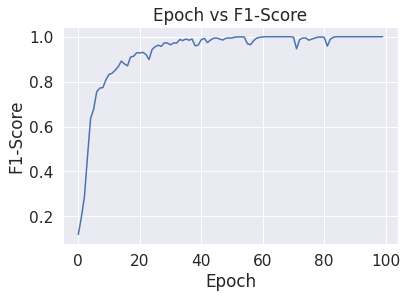

Test F1-Score 0.9491006135940552, Época:98

Test F1-Score 0.9475574493408203, Época:85

Test F1-Score 0.9475574493408203, Época:86

Test F1-Score 0.9475574493408203, Época:87

Test F1-Score 0.9475574493408203, Época:89


Train F1-Score 1.0, Época:62

Train F1-Score 1.0, Época:63

Train F1-Score 1.0, Época:64

Train F1-Score 1.0, Época:65

Train F1-Score 1.0, Época:66


Validation F1-Score 0.927849531173706, Época:77

Validation F1-Score 0.9260913133621216, Época:51

Validation F1-Score 0.9251436591148376, Época:49

Validation F1-Score 0.9219025373458862, Época:41

Validation F1-Score 0.9209656119346619, Época:79



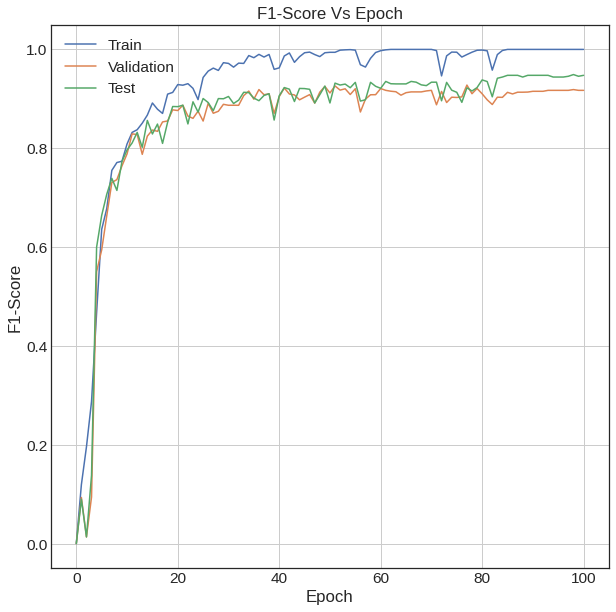

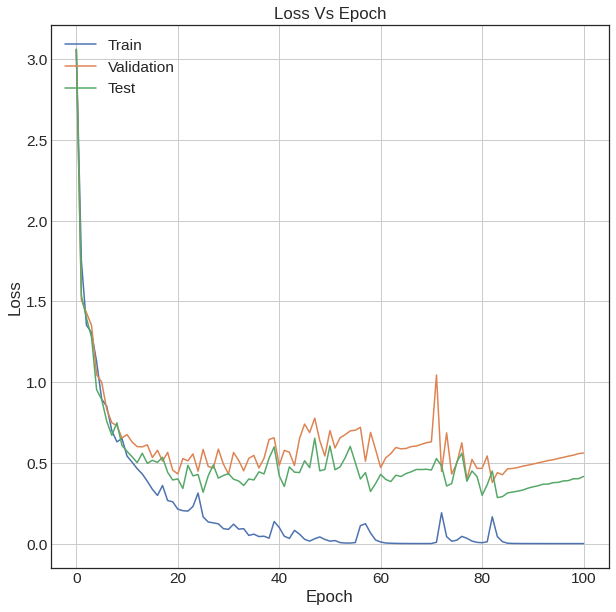

Baseline Error train: 0.00%
Baseline Error dev: 8.28%
Baseline Error test: 5.24%
Accuracy: 1.0
F1 score: 1.0
Recall: 1.0
Precision: 1.0

 clasification report:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       667
         3.0       1.00      1.00      1.00        24
         4.0       1.00      1.00      1.00        28
         9.0       1.00      1.00      1.00       372
        12.0       1.00      1.00      1.00       210
        13.0       1.00      1.00      1.00        55
        14.0       1.00      1.00      1.00        79
        16.0       1.00      1.00      1.00        19
        17.0       1.00      1.00      1.00       443
        18.0       1.00      1.00      1.00       133
        19.0       1.00      1.00      1.00        82
        20.0       1.00      1.00      1.00       161

    accuracy                           1.00      2273
   macro avg       1.00      1.00      1.00      2273
weighted avg       1.00    

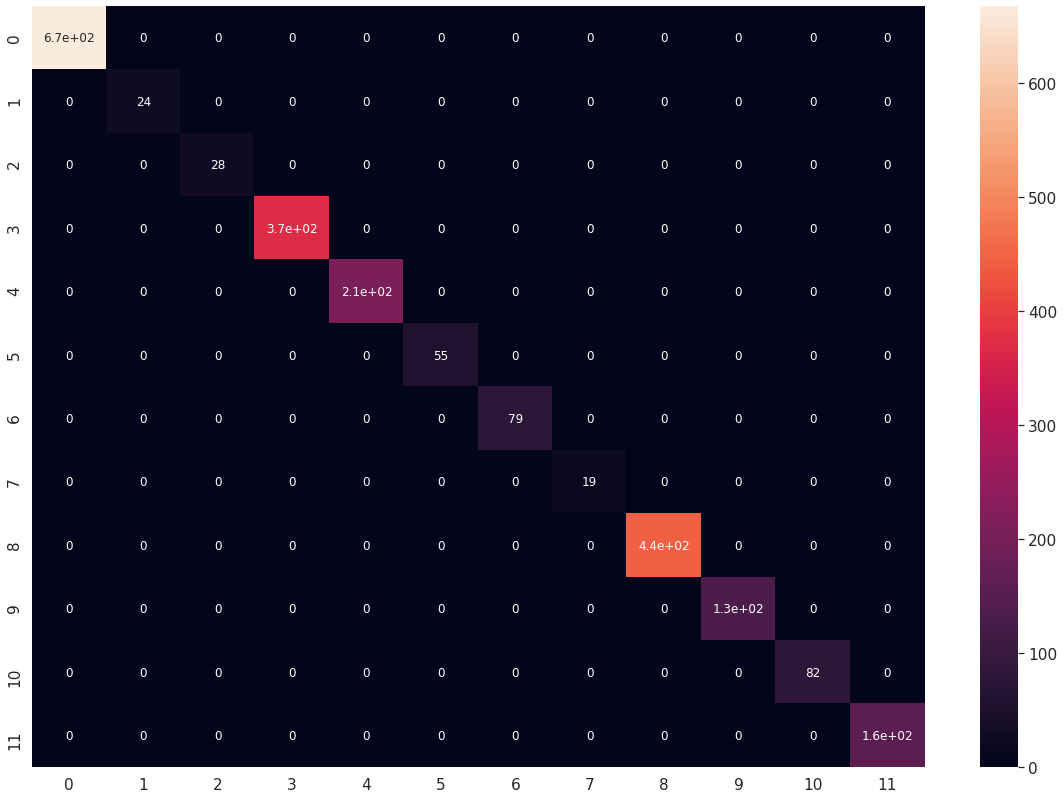

Accuracy: 0.9190140845070423
F1 score: 0.9190178657132804
Recall: 0.9190140845070423
Precision: 0.9206420415065906

 clasification report:
               precision    recall  f1-score   support

         1.0       0.98      1.00      0.99        88
         3.0       1.00      0.80      0.89         5
         4.0       0.86      0.86      0.86         7
         9.0       0.97      0.94      0.96        34
        12.0       0.83      0.88      0.86        34
        13.0       0.50      0.50      0.50         2
        14.0       0.77      0.91      0.83        11
        16.0       0.67      0.67      0.67         3
        17.0       0.98      0.96      0.97        48
        18.0       0.79      0.73      0.76        15
        19.0       0.82      0.82      0.82        17
        20.0       0.94      0.85      0.89        20

    accuracy                           0.92       284
   macro avg       0.84      0.83      0.83       284
weighted avg       0.92      0.92      0.92     

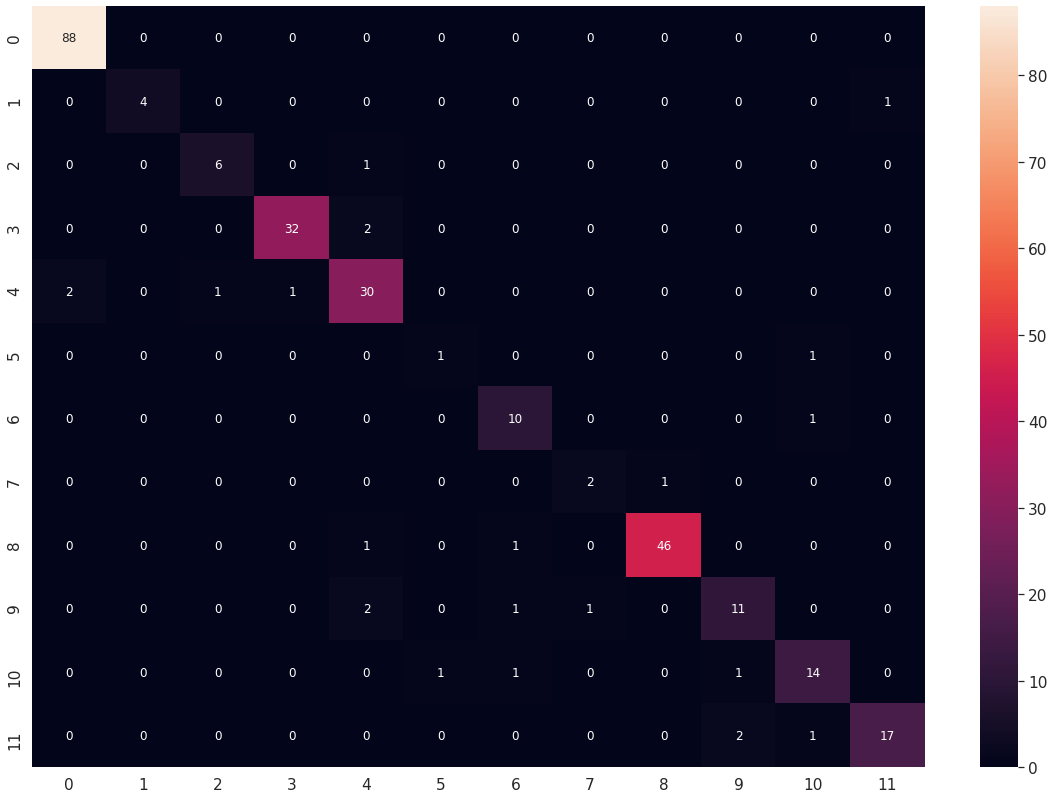

Accuracy: 0.9473684210526315
F1 score: 0.9459946335243657
Recall: 0.9473684210526315
Precision: 0.9481065650303838

 clasification report:
               precision    recall  f1-score   support

         1.0       1.00      0.99      0.99        79
         3.0       0.75      1.00      0.86         3
         4.0       0.00      0.00      0.00         1
         9.0       0.93      1.00      0.96        39
        12.0       1.00      0.86      0.93        37
        13.0       1.00      0.83      0.91         6
        14.0       0.83      0.91      0.87        11
        16.0       0.60      0.60      0.60         5
        17.0       0.98      1.00      0.99        60
        18.0       0.76      0.93      0.84        14
        19.0       0.86      0.75      0.80         8
        20.0       0.95      0.95      0.95        22

    accuracy                           0.95       285
   macro avg       0.81      0.82      0.81       285
weighted avg       0.95      0.95      0.95     

/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioml/anaconda3/envs/tf22/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


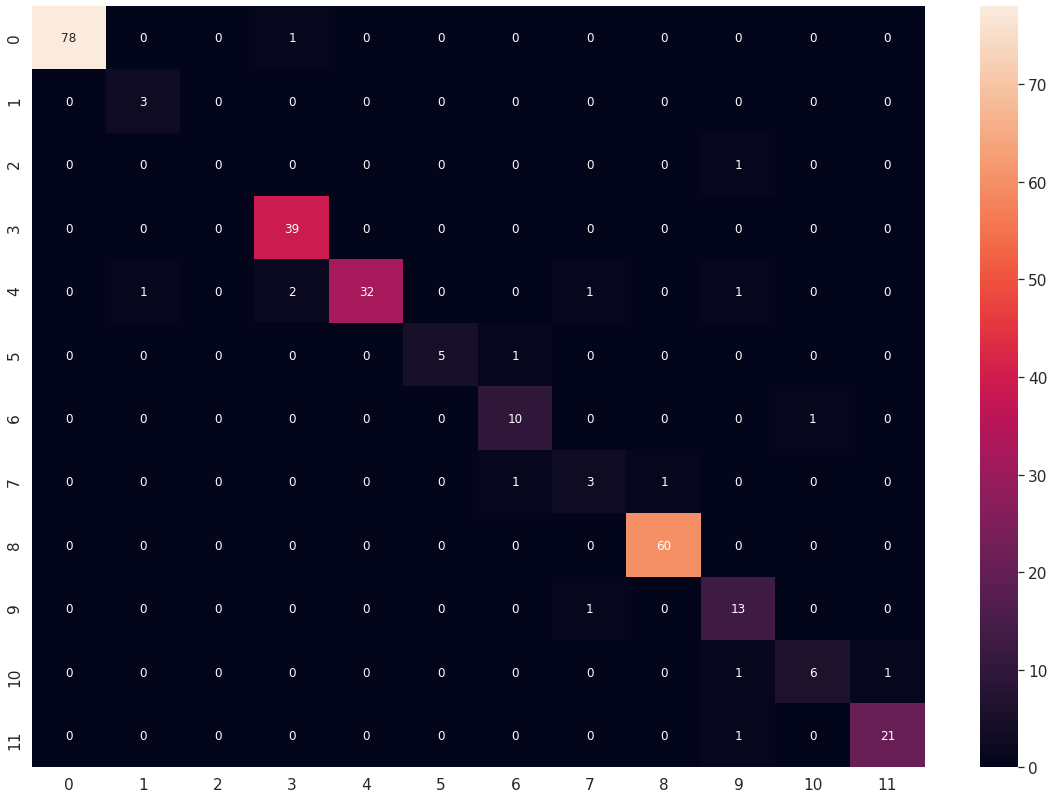

In [27]:
model = TERL()
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

one_hot_labels_train = tf.keras.utils.to_categorical(Y_train, num_classes=21)
one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=21)

# Fit the model
epochs = 100
batch_size = 32

train(model, X_train, one_hot_labels_train, X_dev, one_hot_labels_validation, X_test, one_hot_labels_test, batch_size, epochs, "TERL")
Final_Results_Test(log_Dir) 

# plot metrics
plt.plot(history.history['f1_m'])
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Epoch vs F1-Score')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)

scores = model.evaluate(X_train, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_dev, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_test, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_train)

metrics(Y_train, [argmax(x) for x in predictions])

predictions = model.predict(X_dev)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_test)

metrics(Y_test, [argmax(x) for x in predictions])

# Using TERL representation (method 6)

In [28]:
X = np.load('/home/bioml/Projects/PhD/InpactorDB/version_final/Non-Redundant/InpactorDB_Repbase.fasta.filtered_TERL.npy')
Y = np.load('/home/bioml/Projects/PhD/InpactorDB/version_final/Non-Redundant/InpactorDB_Repbase.fasta.filtered_TERL_labels.npy')

print(X.shape)
print(Y.shape)

(2842, 6, 22576)
(2842, 1)


In [29]:
#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_train, X_test_dev, Y_train, Y_test_dev = train_test_split(X, Y, test_size=validation_size, random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)

print(X_train.shape)
print(Y_train.shape)
print(X_dev.shape)
print(Y_dev.shape)
print(X_test.shape)
print(Y_test.shape)

X = None
Y = None
path_log_base = './logs_CNN'

(2273, 6, 22576)
(2273, 1)
(284, 6, 22576)
(284, 1)
(285, 6, 22576)
(285, 1)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 22576, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 22557, 64)      6464      
_________________________________________________________________
average_pooling2d (AveragePo (None, 2, 2255, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2236, 32)       40992     
_________________________________________________________________
average_pooling2d_1 (Average (None, 2, 149, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 115, 32)        35872     
_________________________________________________________________
average_pooling2d_2 (Average (None, 2, 7, 32)          0     

72/72 [==============================] - 2s 31ms/step - loss: 1.0107e-04 - f1_m: 1.0000 - val_loss: 0.5410 - val_f1_m: 0.9306
Epoch 47/100
72/72 [==============================] - 2s 31ms/step - loss: 8.4569e-05 - f1_m: 1.0000 - val_loss: 0.5534 - val_f1_m: 0.9306
Epoch 48/100
72/72 [==============================] - 2s 31ms/step - loss: 8.4115e-05 - f1_m: 1.0000 - val_loss: 0.5640 - val_f1_m: 0.9306
Epoch 49/100
72/72 [==============================] - 2s 31ms/step - loss: 6.6195e-05 - f1_m: 1.0000 - val_loss: 0.5679 - val_f1_m: 0.9340
Epoch 50/100
72/72 [==============================] - 2s 31ms/step - loss: 5.6582e-05 - f1_m: 1.0000 - val_loss: 0.5695 - val_f1_m: 0.9340
Epoch 51/100
72/72 [==============================] - 2s 31ms/step - loss: 4.8394e-05 - f1_m: 1.0000 - val_loss: 0.5767 - val_f1_m: 0.9306
Epoch 52/100
72/72 [==============================] - 2s 31ms/step - loss: 4.2300e-05 - f1_m: 1.0000 - val_loss: 0.5795 - val_f1_m: 0.9306
Epoch 53/100
72/72 [====================

Loss=0.4319 y F1-Score=0.8590

saved-model-010-0.8673.hdf5
Loss=0.4094 y F1-Score=0.8651

saved-model-011-0.8758.hdf5
Loss=0.4716 y F1-Score=0.8429

saved-model-012-0.8973.hdf5
Loss=0.3284 y F1-Score=0.9063

saved-model-013-0.8692.hdf5
Loss=0.4317 y F1-Score=0.8678

saved-model-014-0.8871.hdf5
Loss=0.3015 y F1-Score=0.9075

saved-model-015-0.9028.hdf5
Loss=0.3810 y F1-Score=0.9067

saved-model-016-0.9214.hdf5
Loss=0.3076 y F1-Score=0.9178

saved-model-017-0.9049.hdf5
Loss=0.4695 y F1-Score=0.8832

saved-model-018-0.9104.hdf5
Loss=0.3327 y F1-Score=0.9119

saved-model-019-0.9152.hdf5
Loss=0.3293 y F1-Score=0.9082

saved-model-020-0.9268.hdf5
Loss=0.3785 y F1-Score=0.9116

saved-model-021-0.9124.hdf5
Loss=0.4332 y F1-Score=0.9037

saved-model-022-0.9129.hdf5
Loss=0.3167 y F1-Score=0.9144

saved-model-023-0.8895.hdf5
Loss=0.4684 y F1-Score=0.8873

saved-model-024-0.9282.hdf5
Loss=0.3833 y F1-Score=0.9066

saved-model-025-0.9146.hdf5
Loss=0.4451 y F1-Score=0.9150

saved-model-026-0.9043.hd

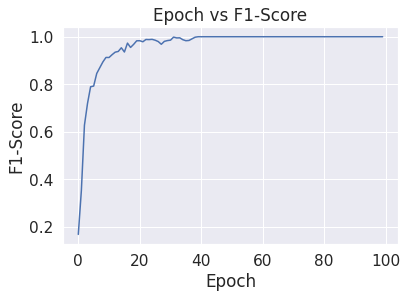

Test F1-Score 0.9371407628059387, Época:40

Test F1-Score 0.935211718082428, Época:39

Test F1-Score 0.9336685538291931, Época:41

Test F1-Score 0.9336685538291931, Época:42

Test F1-Score 0.9336685538291931, Época:43


Train F1-Score 1.0, Época:40

Train F1-Score 1.0, Época:41

Train F1-Score 1.0, Época:42

Train F1-Score 1.0, Época:43

Train F1-Score 1.0, Época:44


Validation F1-Score 0.9375, Época:39

Validation F1-Score 0.9375, Época:76

Validation F1-Score 0.9375, Época:77

Validation F1-Score 0.9375, Época:78

Validation F1-Score 0.9375, Época:79



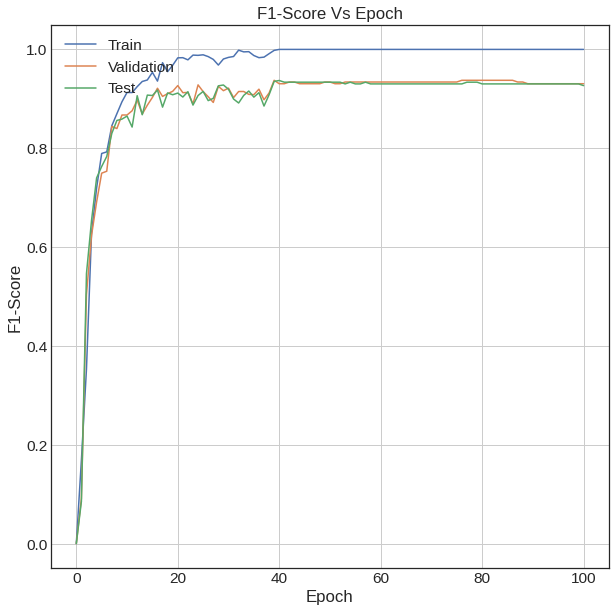

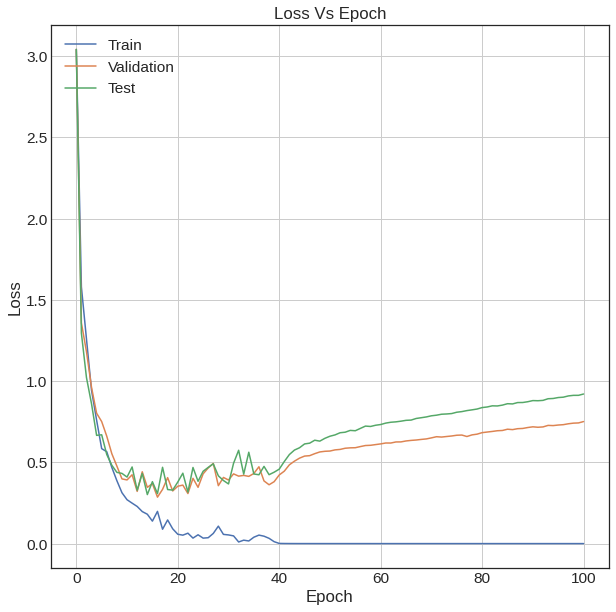

Baseline Error train: 0.00%
Baseline Error dev: 6.94%
Baseline Error test: 7.33%
Accuracy: 1.0
F1 score: 1.0
Recall: 1.0
Precision: 1.0

 clasification report:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       667
         3.0       1.00      1.00      1.00        24
         4.0       1.00      1.00      1.00        28
         9.0       1.00      1.00      1.00       372
        12.0       1.00      1.00      1.00       210
        13.0       1.00      1.00      1.00        55
        14.0       1.00      1.00      1.00        79
        16.0       1.00      1.00      1.00        19
        17.0       1.00      1.00      1.00       443
        18.0       1.00      1.00      1.00       133
        19.0       1.00      1.00      1.00        82
        20.0       1.00      1.00      1.00       161

    accuracy                           1.00      2273
   macro avg       1.00      1.00      1.00      2273
weighted avg       1.00    

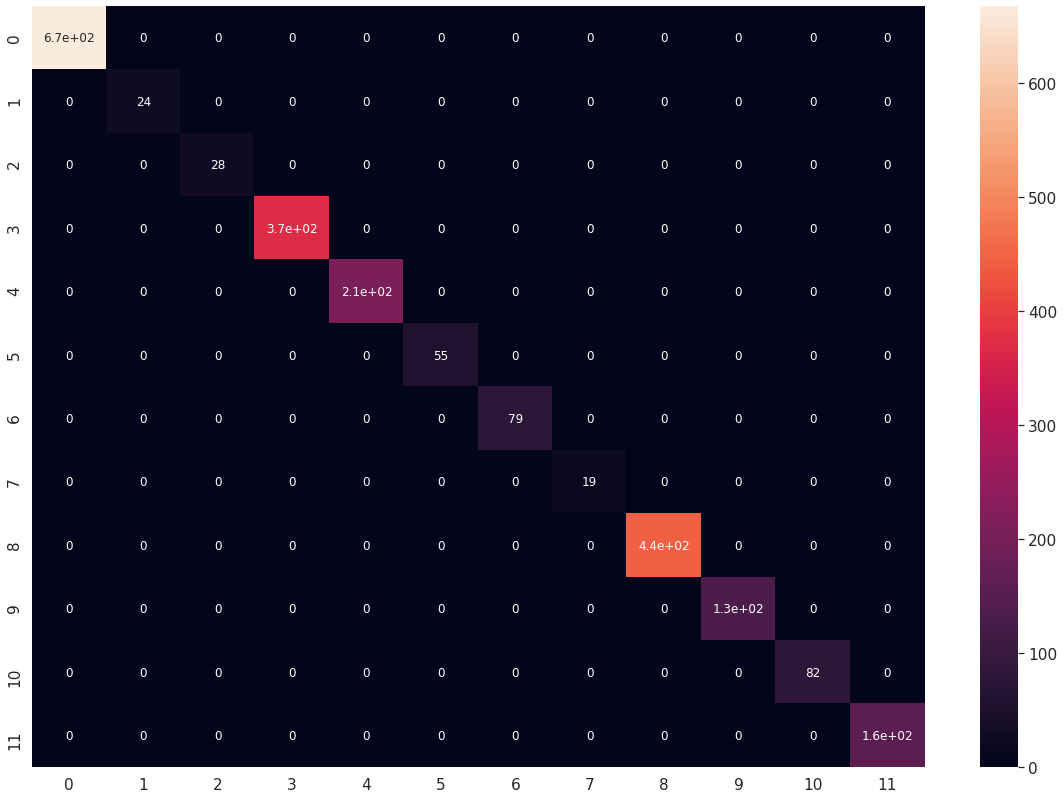

Accuracy: 0.9295774647887324
F1 score: 0.9283157537356646
Recall: 0.9295774647887324
Precision: 0.9311183730197814

 clasification report:
               precision    recall  f1-score   support

         1.0       0.98      0.98      0.98        88
         3.0       1.00      1.00      1.00         5
         4.0       1.00      1.00      1.00         7
         9.0       0.92      0.97      0.94        34
        12.0       0.91      0.94      0.93        34
        13.0       0.67      1.00      0.80         2
        14.0       0.89      0.73      0.80        11
        16.0       0.67      0.67      0.67         3
        17.0       0.90      0.94      0.92        48
        18.0       0.85      0.73      0.79        15
        19.0       1.00      0.76      0.87        17
        20.0       0.91      1.00      0.95        20

    accuracy                           0.93       284
   macro avg       0.89      0.89      0.89       284
weighted avg       0.93      0.93      0.93     

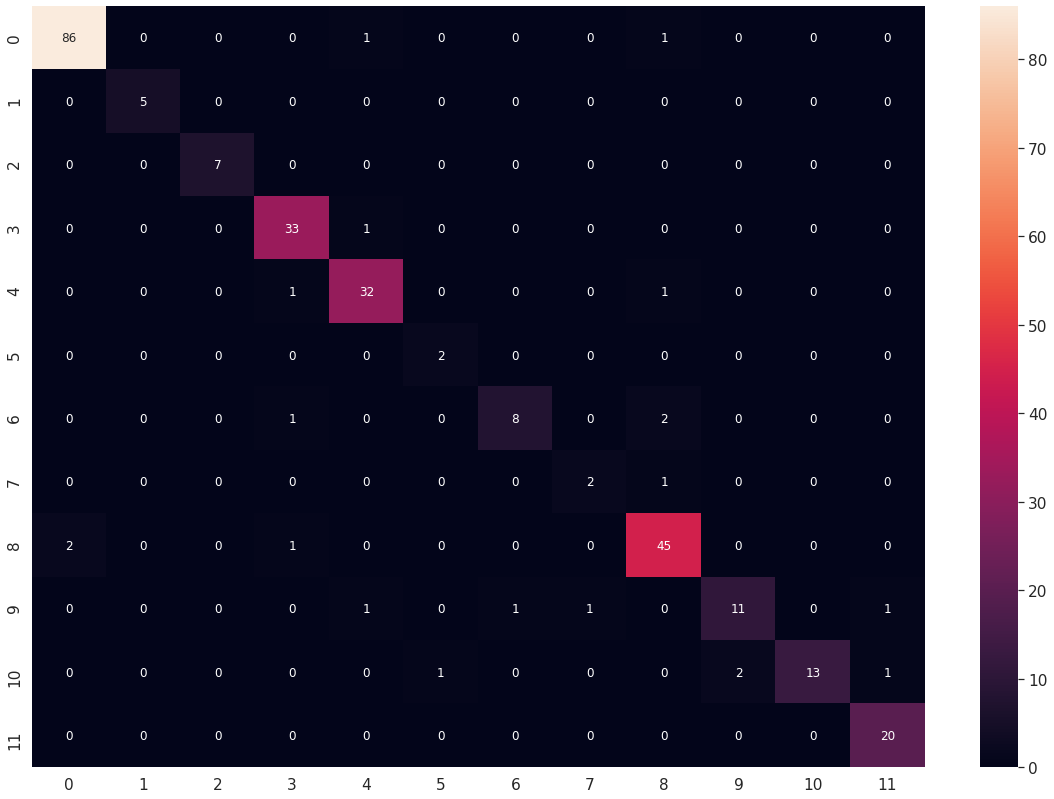

Accuracy: 0.9263157894736842
F1 score: 0.9261407678131092
Recall: 0.9263157894736842
Precision: 0.9292939470534142

 clasification report:
               precision    recall  f1-score   support

         1.0       0.99      0.97      0.98        79
         3.0       1.00      1.00      1.00         3
         4.0       0.50      1.00      0.67         1
         9.0       0.88      0.95      0.91        39
        12.0       0.94      0.81      0.87        37
        13.0       1.00      0.83      0.91         6
        14.0       0.92      1.00      0.96        11
        16.0       0.75      0.60      0.67         5
        17.0       0.95      0.98      0.97        60
        18.0       0.92      0.86      0.89        14
        19.0       0.67      0.75      0.71         8
        20.0       0.87      0.91      0.89        22

    accuracy                           0.93       285
   macro avg       0.87      0.89      0.87       285
weighted avg       0.93      0.93      0.93     

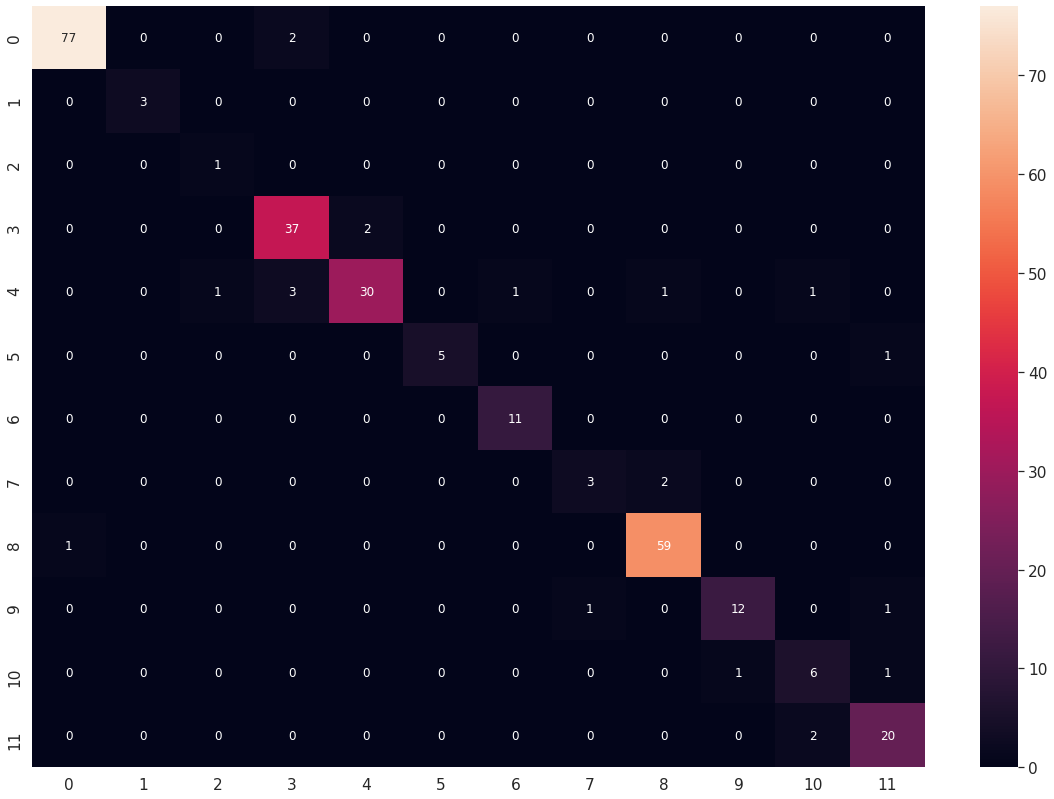

In [30]:
model = TERL()
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

one_hot_labels_train = tf.keras.utils.to_categorical(Y_train, num_classes=21)
one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=21)

# Fit the model
epochs = 100
batch_size = 32

train(model, X_train, one_hot_labels_train, X_dev, one_hot_labels_validation, X_test, one_hot_labels_test, batch_size, epochs, "TERL")
Final_Results_Test(log_Dir) 

# plot metrics
plt.plot(history.history['f1_m'])
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Epoch vs F1-Score')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)

scores = model.evaluate(X_train, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_dev, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_test, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_train)

metrics(Y_train, [argmax(x) for x in predictions])

predictions = model.predict(X_dev)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_test)

metrics(Y_test, [argmax(x) for x in predictions])